<p style="text-align:center;">
<span style="color:rgba(0,0,255,1); font-size:36px;"> Histogram pulse parameters</span>
<br>
<span style="color:grey; font-size:20px"> Creates fingerplot</span>
</p>
<br>
<br>
<span style="color:magenta; font-size:24px"> This notebook is <b>NOT</b> prototype code.</span>

**Table of contents**<a id='toc0_'></a>    
- 1. [select channel](#toc1_)    
- 2. [Function definitions](#toc2_)    
- 3. [load pkl files](#toc3_)    
- 4. [concatenate catalogues](#toc4_)    
- 5. [Exploratory Analysis](#toc5_)    
- 6. [Data Cleaning](#toc6_)    
- 7. [Extract fit_param into dict](#toc7_)    
- 8. [Investigating Paramater distributions](#toc8_)    
  - 8.1. [t0](#toc8_1_)    
  - 8.2. [$\sigma$](#toc8_2_)    
    - 8.2.1. [fitting](#toc8_2_1_)    
  - 8.3. [$\tau$](#toc8_3_)    
  - 8.4. [scale](#toc8_4_)    
- 9. [Cuts:  rectangular cut](#toc9_)    
  - 9.1. [$ \sigma$](#toc9_1_)    
    - 9.1.1. [fitting](#toc9_1_1_)    
  - 9.2. [$\tau$](#toc9_2_)    
    - 9.2.1. [fitting](#toc9_2_1_)    
    - 9.2.2. [Fitting with iMinuit](#toc9_2_2_)    
  - 9.3. [scale](#toc9_3_)    
    - 9.3.1. [fitting](#toc9_3_1_)    
- 10. [FingerPlot](#toc10_)    
- 11. [fit gaussian to finger](#toc11_)    
  - 11.1. [First finger](#toc11_1_)    
  - 11.2. [Second finger](#toc11_2_)    
- 12. [SPE charge](#toc12_)    
- 13. [SNR](#toc13_)    
  - 13.1. [Noise term](#toc13_1_)    
  - 13.2. [SNR calculation](#toc13_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import pickle
import matplotlib.pyplot as plt
from matplotlib import legend
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as patches
import matplotlib.offsetbox as offsetbox
import matplotlib as mpl

In [2]:
from sys import exit

In [3]:
mpl.rcParams['axes.labelsize'] = 14

In [4]:
from matplotlib import rc

In [5]:
# rc('figure', autolayout=True, dpi=125, titlesize=20 )
# rc('font', family='monospace')
# rc('axes', titlesize=22, titleweight='heavy', labelsize=20, labelweight='bold')
# rc(('xtick', 'ytick'), labelsize = 18)
# rc('legend', fontsize=14)
rc('figure', autolayout=True, figsize=[16, 9], dpi=125, titlesize=20 ) # better for presentations
# rc('figure', autolayout=True, figsize=[4, 3], dpi=125, titlesize=20 ) # smaller screen
rc('font', family='monospace')
rc('axes', titlesize=20, titleweight='heavy', labelsize=16, labelweight='bold')
rc(('xtick', 'ytick'), labelsize = 18)
rc('legend', fontsize=14)
rc('lines', linewidth=2.5)
rc('mathtext', default = 'regular')
rc('xtick.minor', visible = True, size = 6)
rc('ytick.minor', visible = True, size = 8)
# rc('axes.formatter', limits=[-1, 1])
np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"})

In [6]:
np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"})

In [7]:
%matplotlib ipympl

# 1. <a id='toc1_'></a>[select channel](#toc0_)

Which channel?

In [8]:
ch_str_ls = ['ch0', 'ch1', 'ch2']

# selected_channel =  input("Choose channel number for processing.")
selected_channel = 0
# selected_channel = 2
print(f"selected channel index: {selected_channel}")
ch_x = ch_str_ls[int(selected_channel)]

selected channel index: 0


# 2. <a id='toc2_'></a>[Function definitions](#toc0_)

In [9]:
def f_gauss(x, g_mean, g_sigma, g_k):
    return g_k*(1/(g_sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-g_mean)/g_sigma)**2)

In [10]:
def red_chisq(f_obs, f_exp, fittedparameters):
    chisqr = np.sum((f_obs - f_exp)**2 / f_exp)
    ndf = f_obs.shape[0]
    return chisqr/(ndf -fittedparameters.shape[0])

In [11]:
## Centre of Mass
def calc_COM(hist_content, hist_edges):
    hist_com = np.divide(np.sum(np.multiply(hist_edges[:-1], hist_content), axis=0), 
                      np.sum(hist_content, axis=0)
                )
    return hist_com

# 3. <a id='toc3_'></a>[load pkl files](#toc0_)

In [12]:
# all_clean_catalogues = []
# for run_number in run_number_ls:
#     all_clean_catalogues.append(f'clean_catalogue_run000{run_number}.pkl')

In [13]:
# selected_clean_catalogue_path = os.path.join(output_folder, all_clean_catalogues[3])
# selected_clean_dict = pickle.load(open(selected_fit_catalogue_path, 'rb'))
# selected_clean_dict #['ch2']

In [14]:
# output_folder = '/home/sarthak/my_projects/argset/output_folder/'
output_folder = '/work/chuck/sarthak/argset/output_folder'
# output_folder = '/work/sarthak/argset/processed_data/backup_ch2/'
# output_folder = '/work/sarthak/argset/processed_data/backup/'
# output_folder = '/work/chuck/sarthak/argset/backup_default_ARMA/output_folder/'

In [15]:
run_number_ls = [52, 53, 54, 61, 62, 63]
# run_number_ls = [52, 61]
# run_number_ls = [52]

In [16]:
all_fit_catalogues = []
for run_number in run_number_ls:
    # all_fit_catalogues.append(f'{output_folder}/fit_catalogue_run000{run_number}.pkl')
    # all_fit_catalogues.append(f'{output_folder}/fit_catalogue_custom_run000{run_number}.pkl')
    all_fit_catalogues.append(f'{output_folder}/fit_catalogue_filteredWF_run000{run_number}.pkl')

In [17]:
all_fit_catalogues

['/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00052.pkl',
 '/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00053.pkl',
 '/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00054.pkl',
 '/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00061.pkl',
 '/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00062.pkl',
 '/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00063.pkl']

In [18]:
fit_dict_52 = pickle.load(open( all_fit_catalogues[0], 'rb'))

In [19]:
fit_dict_53 = pickle.load(open( all_fit_catalogues[1], 'rb'))

In [20]:
fit_dict_54 = pickle.load(open( all_fit_catalogues[2], 'rb'))

In [21]:
fit_dict_61 = pickle.load(open( all_fit_catalogues[3], 'rb'))

In [22]:
fit_dict_62 = pickle.load(open( all_fit_catalogues[4], 'rb'))

In [23]:
fit_dict_63 = pickle.load(open( all_fit_catalogues[4], 'rb'))

# 4. <a id='toc4_'></a>[concatenate catalogues](#toc0_)

In [24]:
fit_dict_ls = [fit_dict_52, fit_dict_53, fit_dict_54, fit_dict_61, fit_dict_62, fit_dict_63]
# fit_dict_ls = [fit_dict_52, fit_dict_53, fit_dict_54]
# fit_dict_ls = [fit_dict_61, fit_dict_62, fit_dict_63]
# fit_dict_ls = [fit_dict_52]
# ch_str_ls = ['ch0', 'ch1', 'ch2'] # original
ch_str_ls = [['ch0', 'ch1', 'ch2'][selected_channel]]
# ch_str_ls = ['ch2']

fit_catalogue = {}
# for ch_x in ch_str_ls: # original
for ch_x in ch_str_ls:
    fit_catalogue_x = []
    for fit_dict in fit_dict_ls:
        fit_catalogue_x.append(fit_dict[ch_x])
    fit_catalogue[ch_x] = pd.concat(fit_catalogue_x, ignore_index=True)

Free up RAM

In [25]:
del fit_dict_53, fit_dict_54, fit_dict_61, fit_dict_62, fit_dict_63

<p> Note: remember event_counter is unique only for a run; for concatenated DataFrames it is no longer unique identifier.</p>

# 5. <a id='toc5_'></a>[Exploratory Analysis](#toc0_)
No longer needed!

the ratio of good fit waveforms to clean forms

In [26]:
# (fit_catalogue['ch0'][fit_catalogue['ch0']['chisqr']< 2.0]).shape[0]/(fit_catalogue['ch0']).shape[0]

In [27]:
# (fit_catalogue['ch1'][fit_catalogue['ch1']['chisqr']< 2.0]).shape[0]/(fit_catalogue['ch1']).shape[0]

In [28]:
# (fit_catalogue['ch2'][fit_catalogue[ch_x]['chisqr']< 2.0]).shape[0]/(fit_catalogue['ch2']).shape[0]

How many times fit failed to converge?

In [29]:
# fit_catalogue['ch0']['fit_param'].isnull().sum()

In [30]:
# fit_catalogue['ch1']['fit_param'].isnull().sum()

In [31]:
# fit_catalogue['ch2']['fit_param'].isnull().sum()

In [32]:
# fit_catalogue['ch0'].index.values.shape

In [33]:
# fit_catalogue['ch0'][fit_catalogue['ch0']['chisqr']< 2.0]

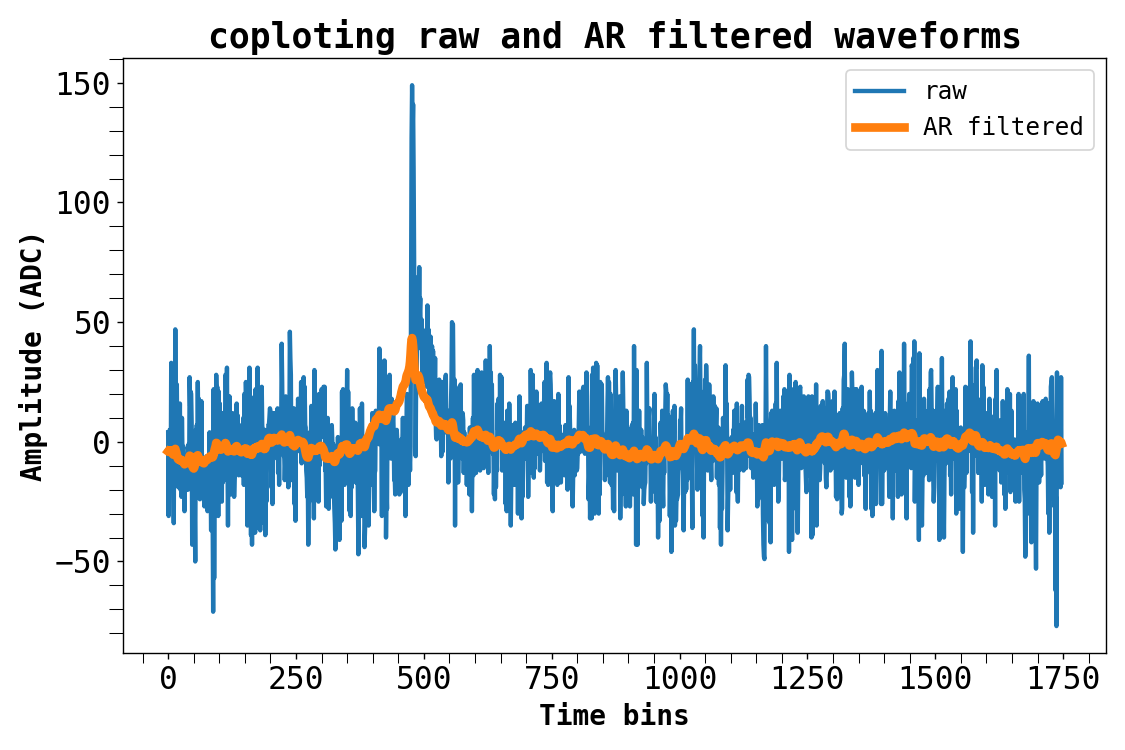

In [34]:
plt.figure(figsize=(9, 6))
plt.title('coploting raw and AR filtered waveforms')

event_value = 10

# plt.plot(fit_dict_52['ch0']['wf_ch0'][event_value], label='raw + shift')
# plt.plot(fit_dict_52['ch0']['wf_raw'][event_value], label='raw')
# plt.plot(fit_dict_52['ch0']['filtered_wf_ch0'][event_value], linewidth=5, label='AR filtered')
plt.plot(fit_dict_52[['ch0', 'ch1', 'ch2'][selected_channel]]['wf_raw'][event_value], label='raw')
plt.plot(fit_dict_52[['ch0', 'ch1', 'ch2'][selected_channel]][f"filtered_wf_{['ch0', 'ch1', 'ch2'][selected_channel]}"][event_value], linewidth=5, label='AR filtered')

plt.xlabel('Time bins')
plt.ylabel('Amplitude (ADC)')
# plt.axhline(y=fit_dict_52['ch0']['fit_param'][event_value][4], color='magenta', label = 'baseline')
plt.legend()

In [35]:
# plt.savefig('../plots/raw_vs_filtered.svg')

In [36]:
# fit_dict_52['ch0']['fit_param'].loc[plot_index][0] < 600

Text(0, 0.5, 'Amplitude (ADC)')

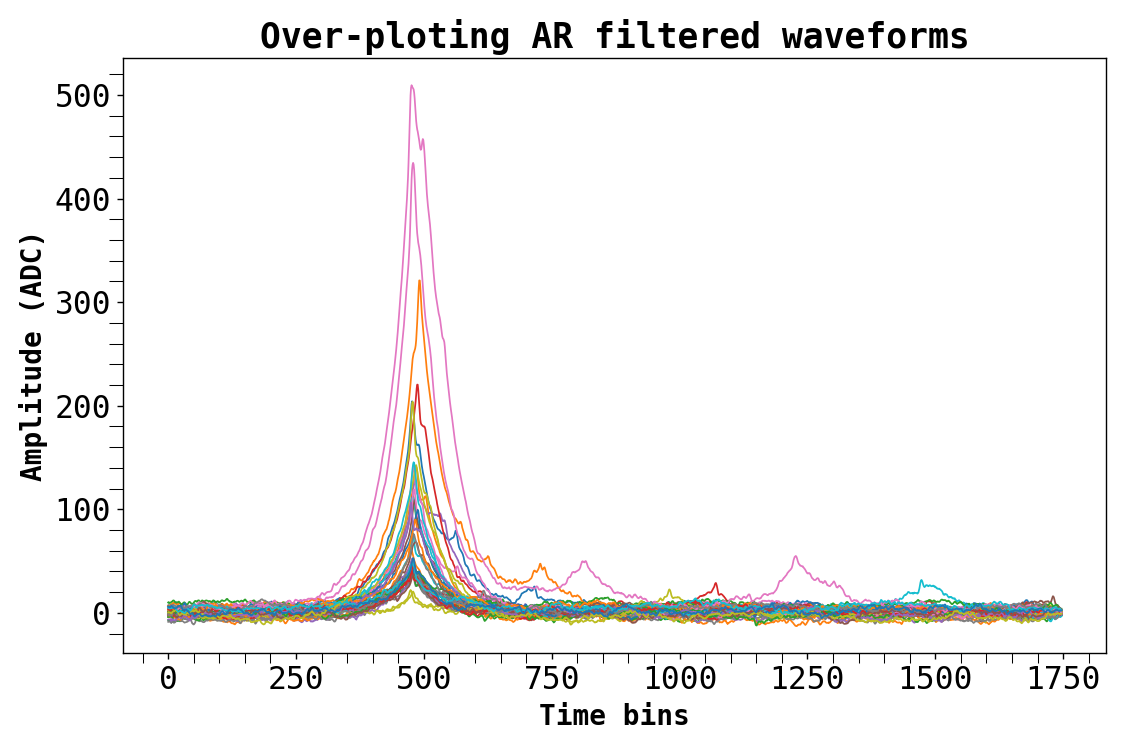

In [37]:
plt.figure(figsize=(9, 6))
plt.title('Over-ploting AR filtered waveforms')
# helps select the t0
event_value = 0

for plot_index in fit_catalogue[ch_x]['wf_raw'].index.values[:50]:
    # if (fit_dict_52['ch0']['fit_param'].loc[plot_index][0] < 600) & (fit_dict_52['ch0']['fit_param'].loc[plot_index][0] > 400):
    #     plt.plot(fit_dict_52['ch0']['filtered_wf_ch0'][plot_index], linewidth=1)
    if (fit_dict_52[['ch0', 'ch1', 'ch2'][selected_channel]]['fit_param'].loc[plot_index][0] < 600) & (fit_dict_52[f"{['ch0', 'ch1', 'ch2'][selected_channel]}"]['fit_param'].loc[plot_index][0] > 400):
        plt.plot(fit_dict_52[['ch0', 'ch1', 'ch2'][selected_channel]][f"filtered_wf_{['ch0', 'ch1', 'ch2'][selected_channel]}"][plot_index], linewidth=1)
plt.xlabel('Time bins')
plt.ylabel('Amplitude (ADC)')
# plt.savefig('../plots/over_ploting_filtered_Wf.svg')

In [38]:
del fit_dict_52

# 6. <a id='toc6_'></a>[Data Cleaning](#toc0_)

Drop NA rows

In [39]:
for ch_index in ch_str_ls:
    fit_catalogue[ch_index] = fit_catalogue[ch_index].dropna()

In [40]:
# sanity check: dropna works!
# fit_catalogue['ch0']['fit_param'].isnull().sum()

# 7. <a id='toc7_'></a>[Extract fit_param into dict](#toc0_)

extracting param values

In [41]:
param_dict = {}
for ch_index in ch_str_ls:
    t0_ls = []
    sigma_ls = []
    tau_ls = []
    scale_ls = []
    fit_param_x = {}
    for loop_index in fit_catalogue[ch_index].index.values:
        loop_fit_param = fit_catalogue[ch_index].loc[loop_index]['fit_param']
        t0_ls.append(loop_fit_param[0])
        sigma_ls.append(loop_fit_param[1])
        tau_ls.append(loop_fit_param[2])
        scale_ls.append(loop_fit_param[3])
    fit_param_x['t0'] = t0_ls
    fit_param_x['sigma'] = sigma_ls
    fit_param_x['tau'] = tau_ls
    fit_param_x['scale'] = scale_ls
    param_dict[ch_index] = fit_param_x

# 8. <a id='toc8_'></a>[Investigating Paramater distributions](#toc0_)

## 8.1. <a id='toc8_1_'></a>[t0](#toc0_)

Text(0.5, 1.0, 't0')

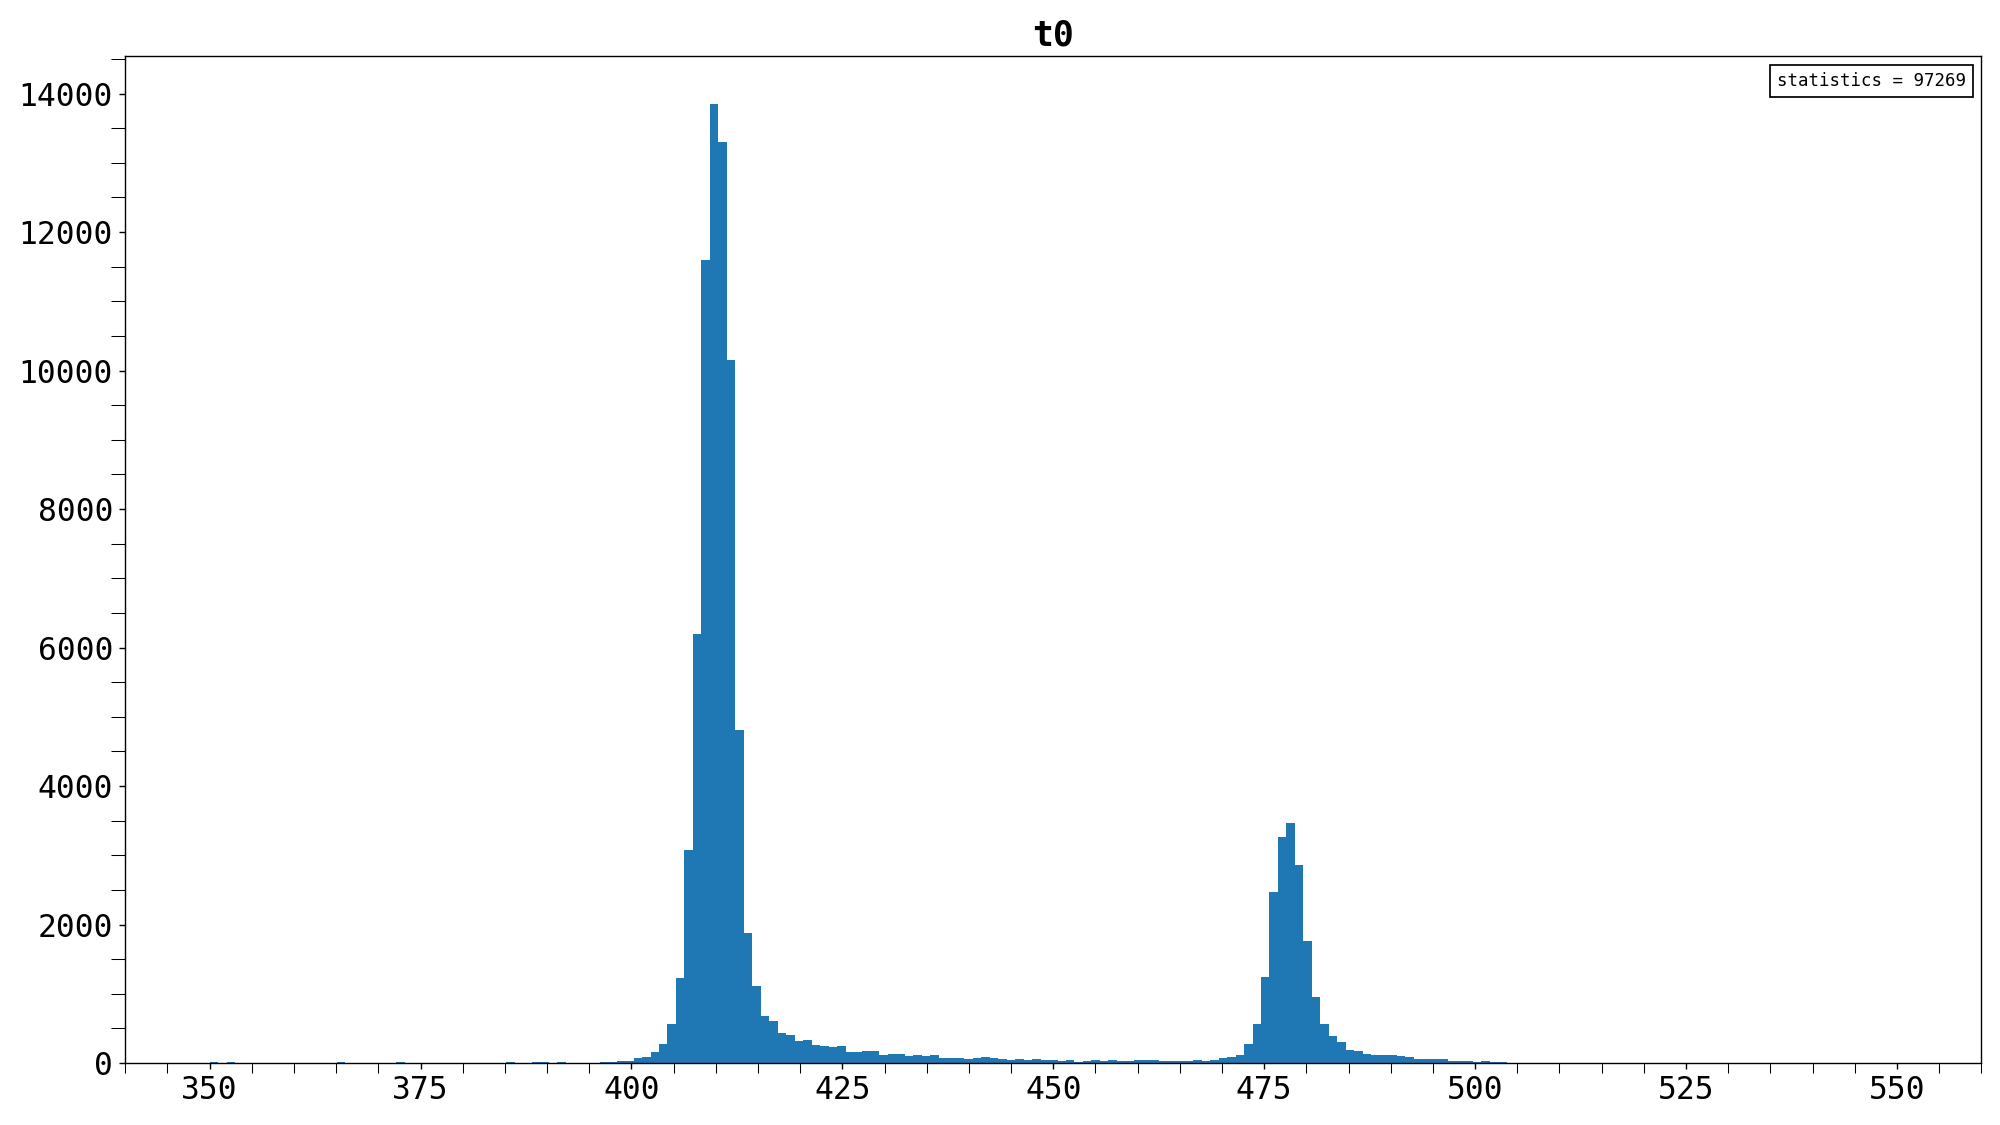

In [42]:
plt.close(1)
fig1, ax1 = plt.subplots()
text_in_box = AnchoredText(f"statistics = {len(param_dict[ch_x]['t0'])}", \
                                       loc='upper right')
ax1.add_artist(text_in_box)
ax1.hist(param_dict[ch_x]['t0'], bins = np.linspace(350, 550, 200))
ax1.set_title('t0')

## 8.2. <a id='toc8_2_'></a>[$\sigma$](#toc0_)

Text(0.5, 1.0, '$\\sigma$')

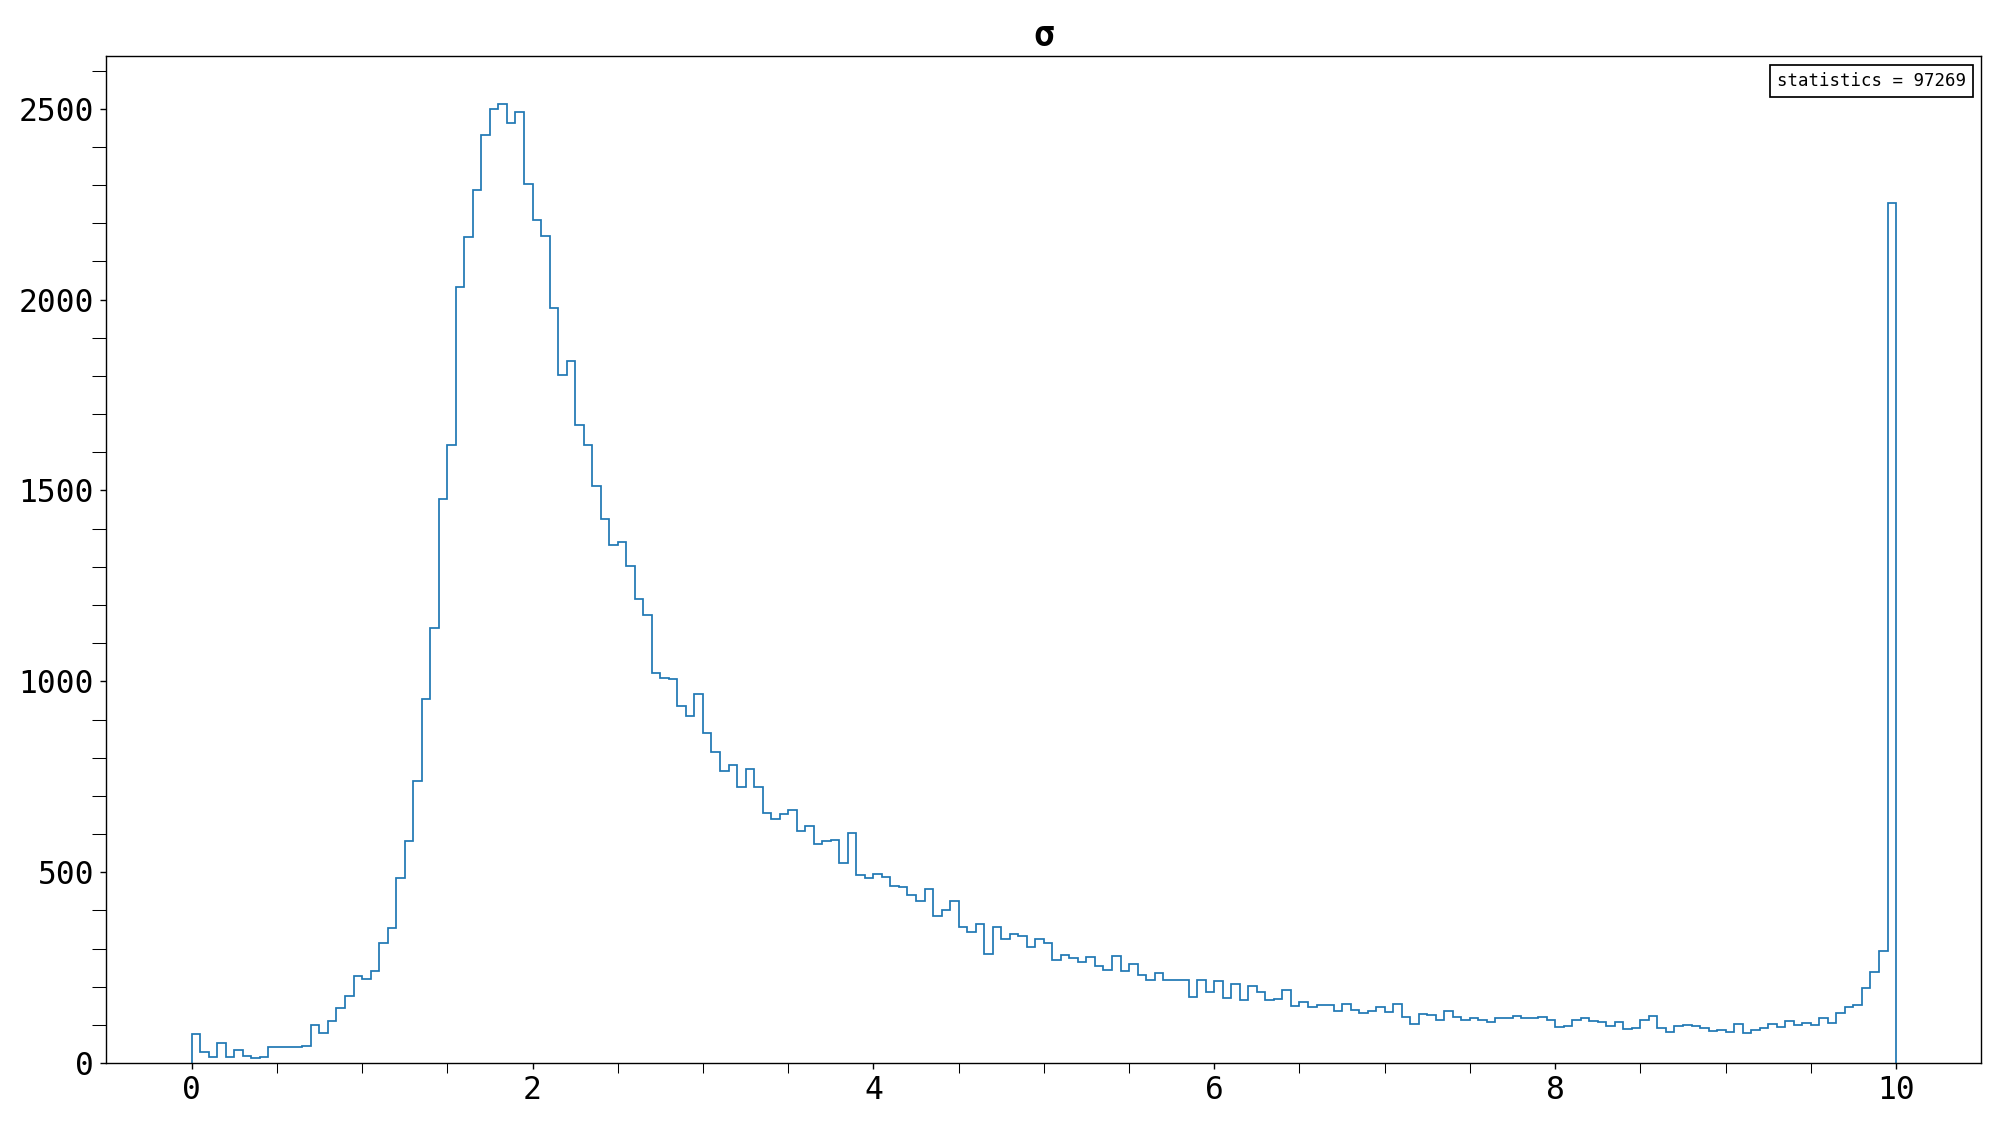

In [43]:
plt.close(2)
fig2, ax2 = plt.subplots()
hist_content, hist_edges, _hist_obj= ax2.hist(param_dict[ch_x]['sigma'], bins=200, histtype='step', label = 'data') #, bins= np.linspace(1.0, 6.0, 10))
text_in_box = AnchoredText(f"statistics = {len(param_dict[ch_x]['sigma'])}", \
                                       loc='upper right')
ax2.add_artist(text_in_box)
ax2.set_title('$\\sigma$')

### 8.2.1. <a id='toc8_2_1_'></a>[fitting](#toc0_)

In [44]:
x_range = range(30, 49)

p0_input = [2, 0.45, 500.0] ## ch2 & ch1

# bounds_input = ([1.0, 0.0, 500.0], [10.0, 1.0, 600.0]) ## ch2
bounds_input = ([1.0, 0.0, 0.0], [10.0, 1.0, np.inf]) ## ch1

fitted_parameters, _pcov = curve_fit(f_gauss, 
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input, 
                            bounds = bounds_input,
                            sigma = np.sqrt(hist_content[x_range]),
                            absolute_sigma=True,
                            )

chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters), fitted_parameters
    )

ax2.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters), 
        #  color='red', 
         label='fitted function')
ax2.legend()
chisqr_in_box = AnchoredText(f"red. chisqr = {chisqr_value:.2f}", \
                                       loc='center right')
ax2.add_artist(chisqr_in_box)

chisqr_value

7.51112143279985

In [45]:
fitted_parameters

array([     1.849,     0.4906,       2960])

In [46]:
legend_obj_ax2 = ax2.legend(loc='best', bbox_to_anchor=[1.0, 0.90])

In [47]:
# legend.DraggableLegend(legend_obj_ax2)

In [48]:
# pickle.dump( (fig2, ax2), open('ax2_plot.pkl', 'wb')) ## writes plot to file

## 8.3. <a id='toc8_3_'></a>[$\tau$](#toc0_)

Text(0.5, 1.0, '$\\tau$')

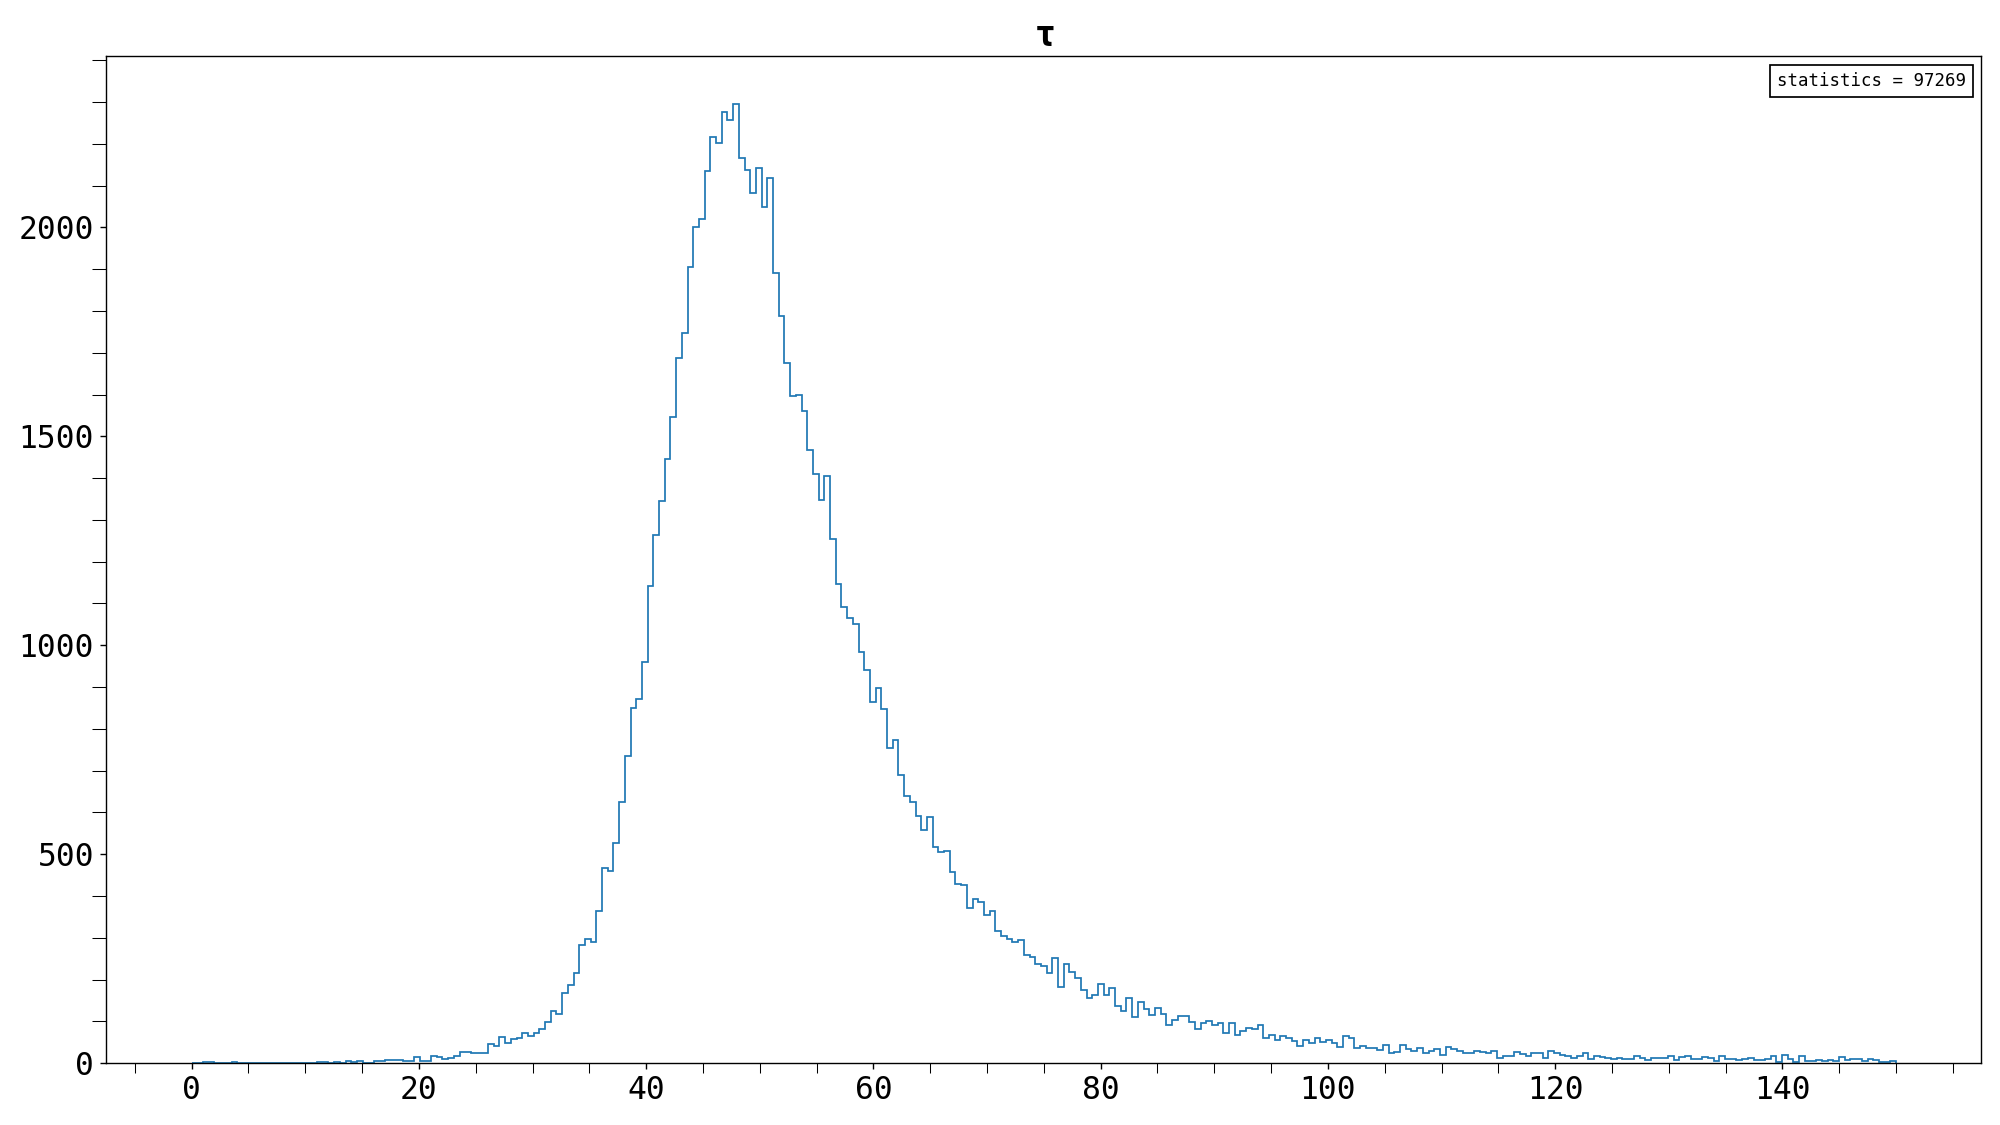

In [49]:
plt.close(3)
fig3, ax3 = plt.subplots()
ax3.hist = plt.hist(param_dict[ch_x]['tau'], bins= np.linspace(0.0, 150.0, 300), histtype='step')
text_in_box = AnchoredText(f"statistics = {len(param_dict[ch_x]['tau'])}", \
                                       loc='upper right')
ax3.add_artist(text_in_box)
ax3.set_title('$\\tau$')

## 8.4. <a id='toc8_4_'></a>[scale](#toc0_)

Text(0.5, 1.0, 'scale')

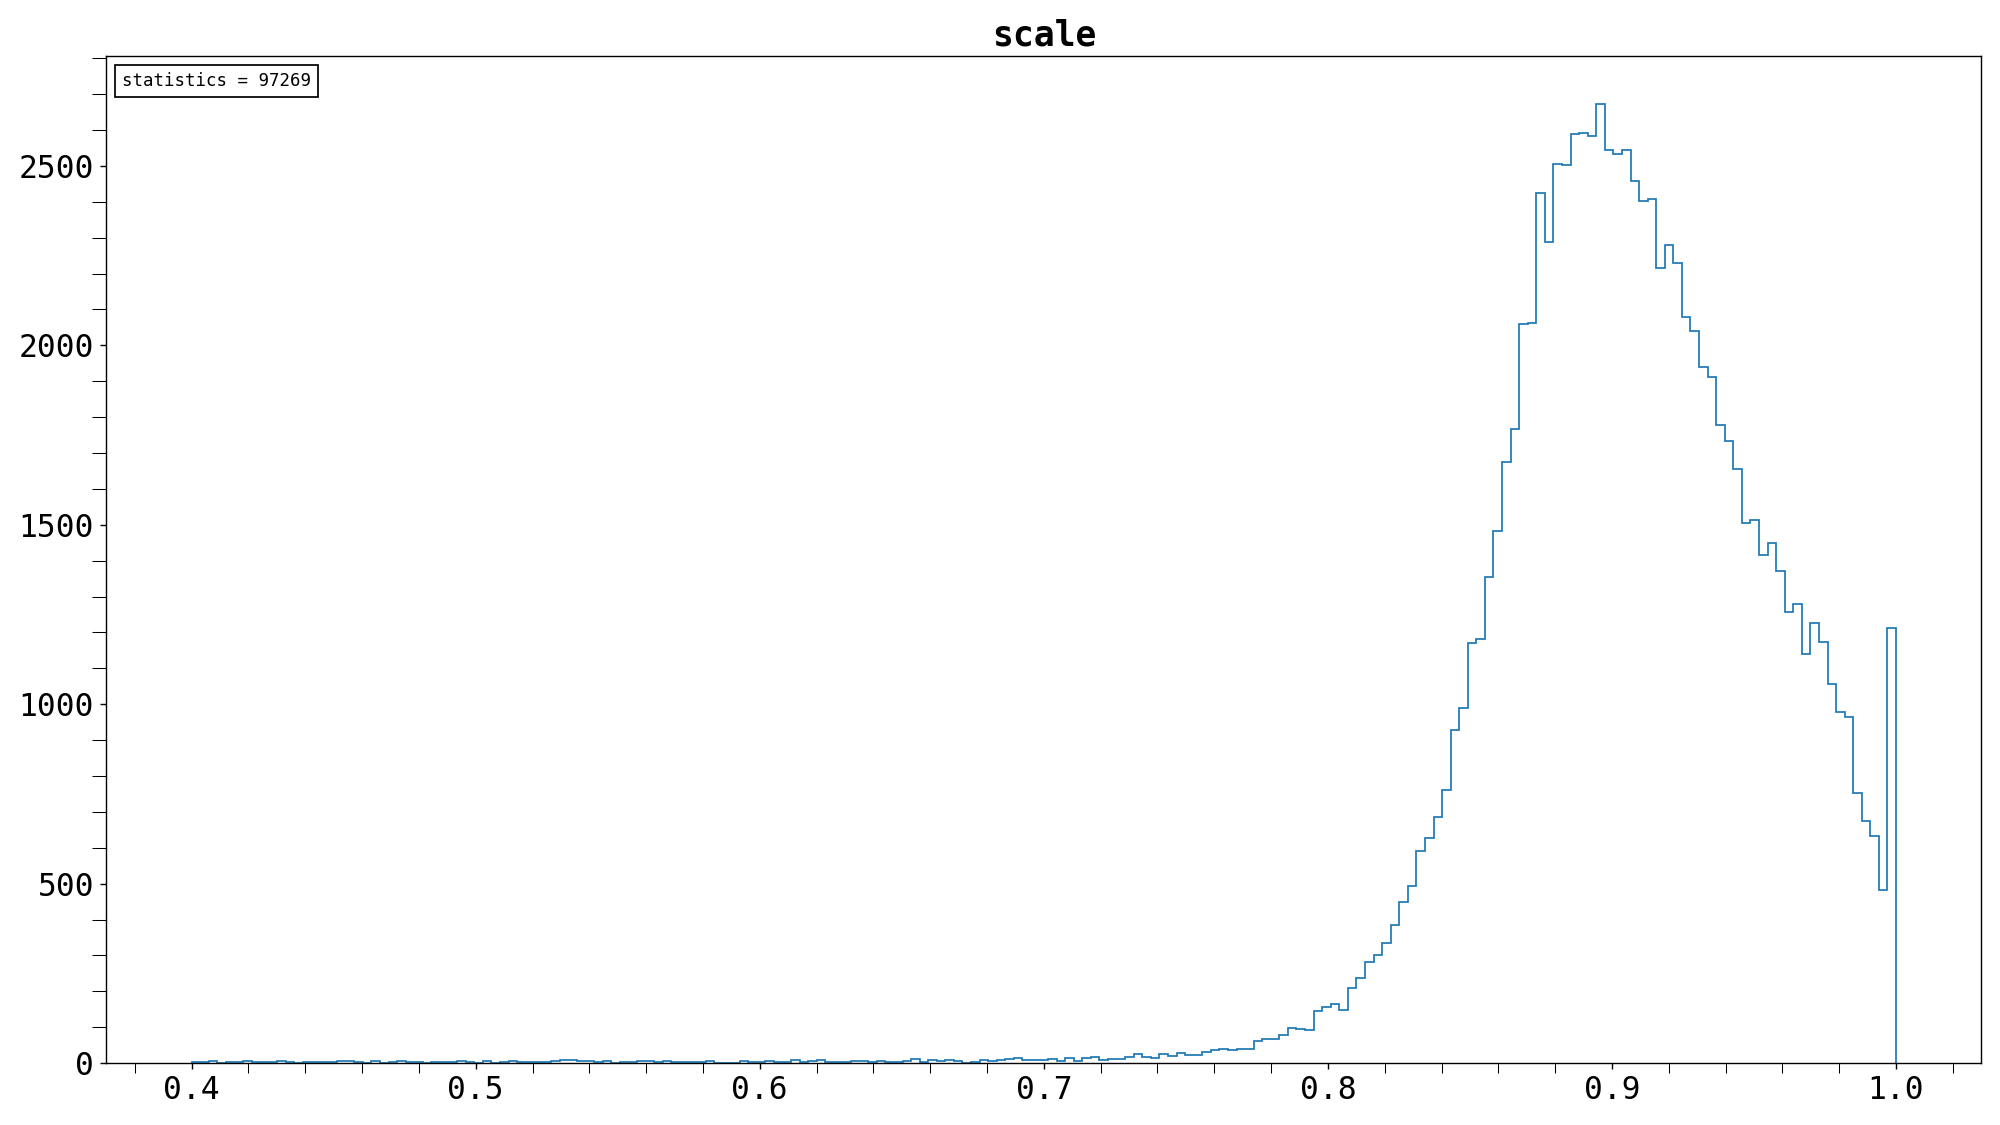

No such comm: c6c66017b6404143beb510c90a99fb05


In [50]:
plt.close(4)
fig4, ax4 = plt.subplots()
ax4.hist(param_dict[ch_x]['scale'], bins= np.linspace(0.4, 1.0, 200), histtype='step')
text_in_box = AnchoredText(f"statistics = {len(param_dict[ch_x]['scale'])}", \
                                       loc='upper left')
ax4.add_artist(text_in_box)
ax4.set_title('scale')

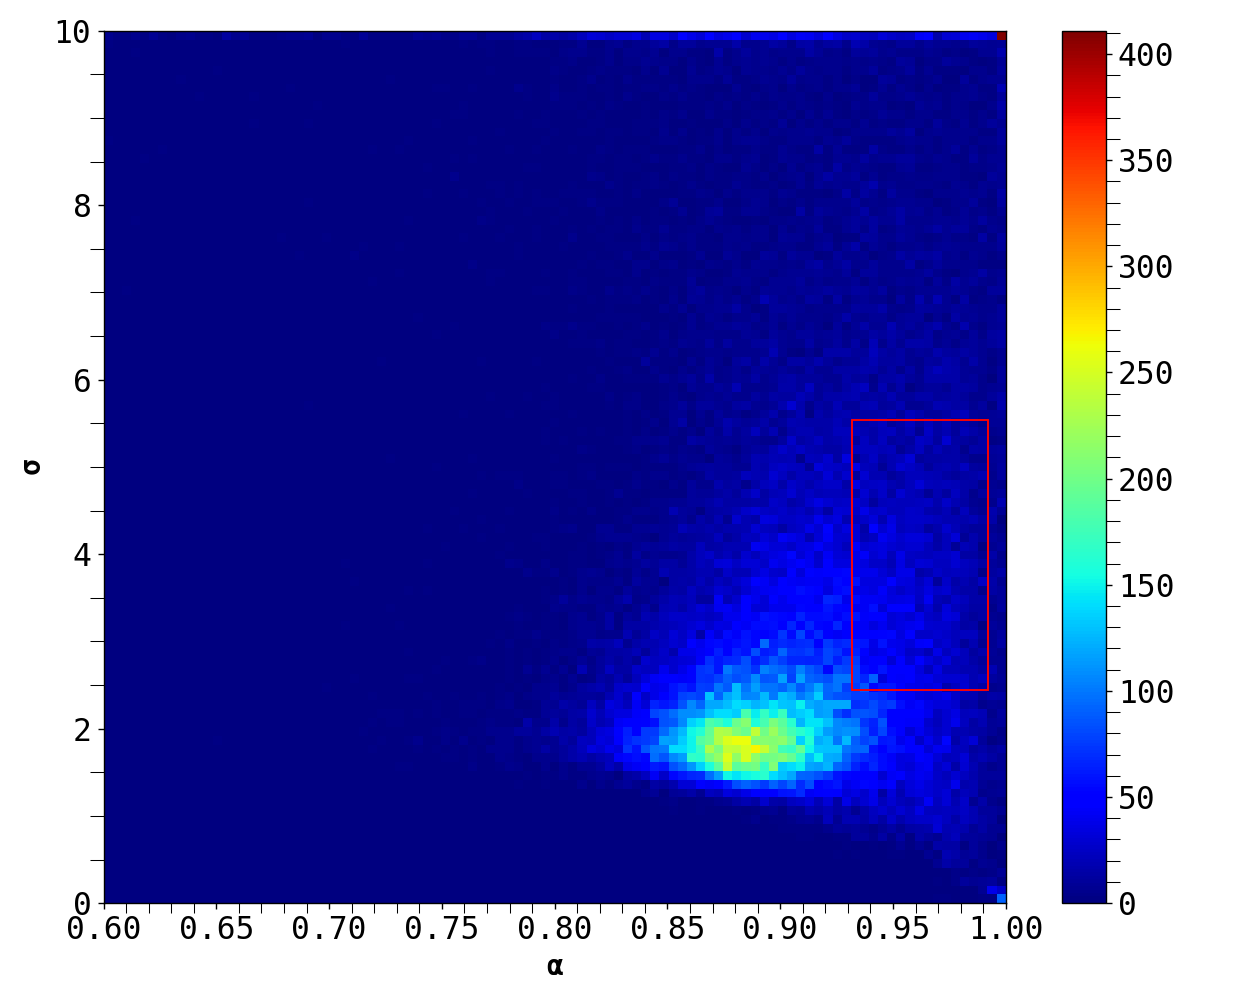

In [51]:
plt.close(5)
red_win = patches.Rectangle((0.932, 2.44), 0.06, 3.10, linewidth=1.1, edgecolor='r', facecolor='none')
fig5, ax5 = plt.subplots(figsize=(10, 8))
hist_h, hist_xedges, hist_yedges, hist_im = ax5.hist2d(param_dict[ch_x]['scale'], \
                    param_dict[ch_x]['sigma'], bins = [np.linspace(0.6, 1.0, 100), np.linspace(0., 10., 100)], \
                    cmap='jet')
ax5.add_patch(red_win)
ax5.set_xlabel('$\\alpha$')
ax5.set_ylabel('$\\sigma$')
fig5.colorbar(hist_im)
# ax5.set_title(f' {ch_x}: $\\alpha$ vs $\\sigma$'); %Thesis figures probably don't need figure titles.
fig5.savefig('../plots/ch0_alphVSsigma_rectangular_cut.png')

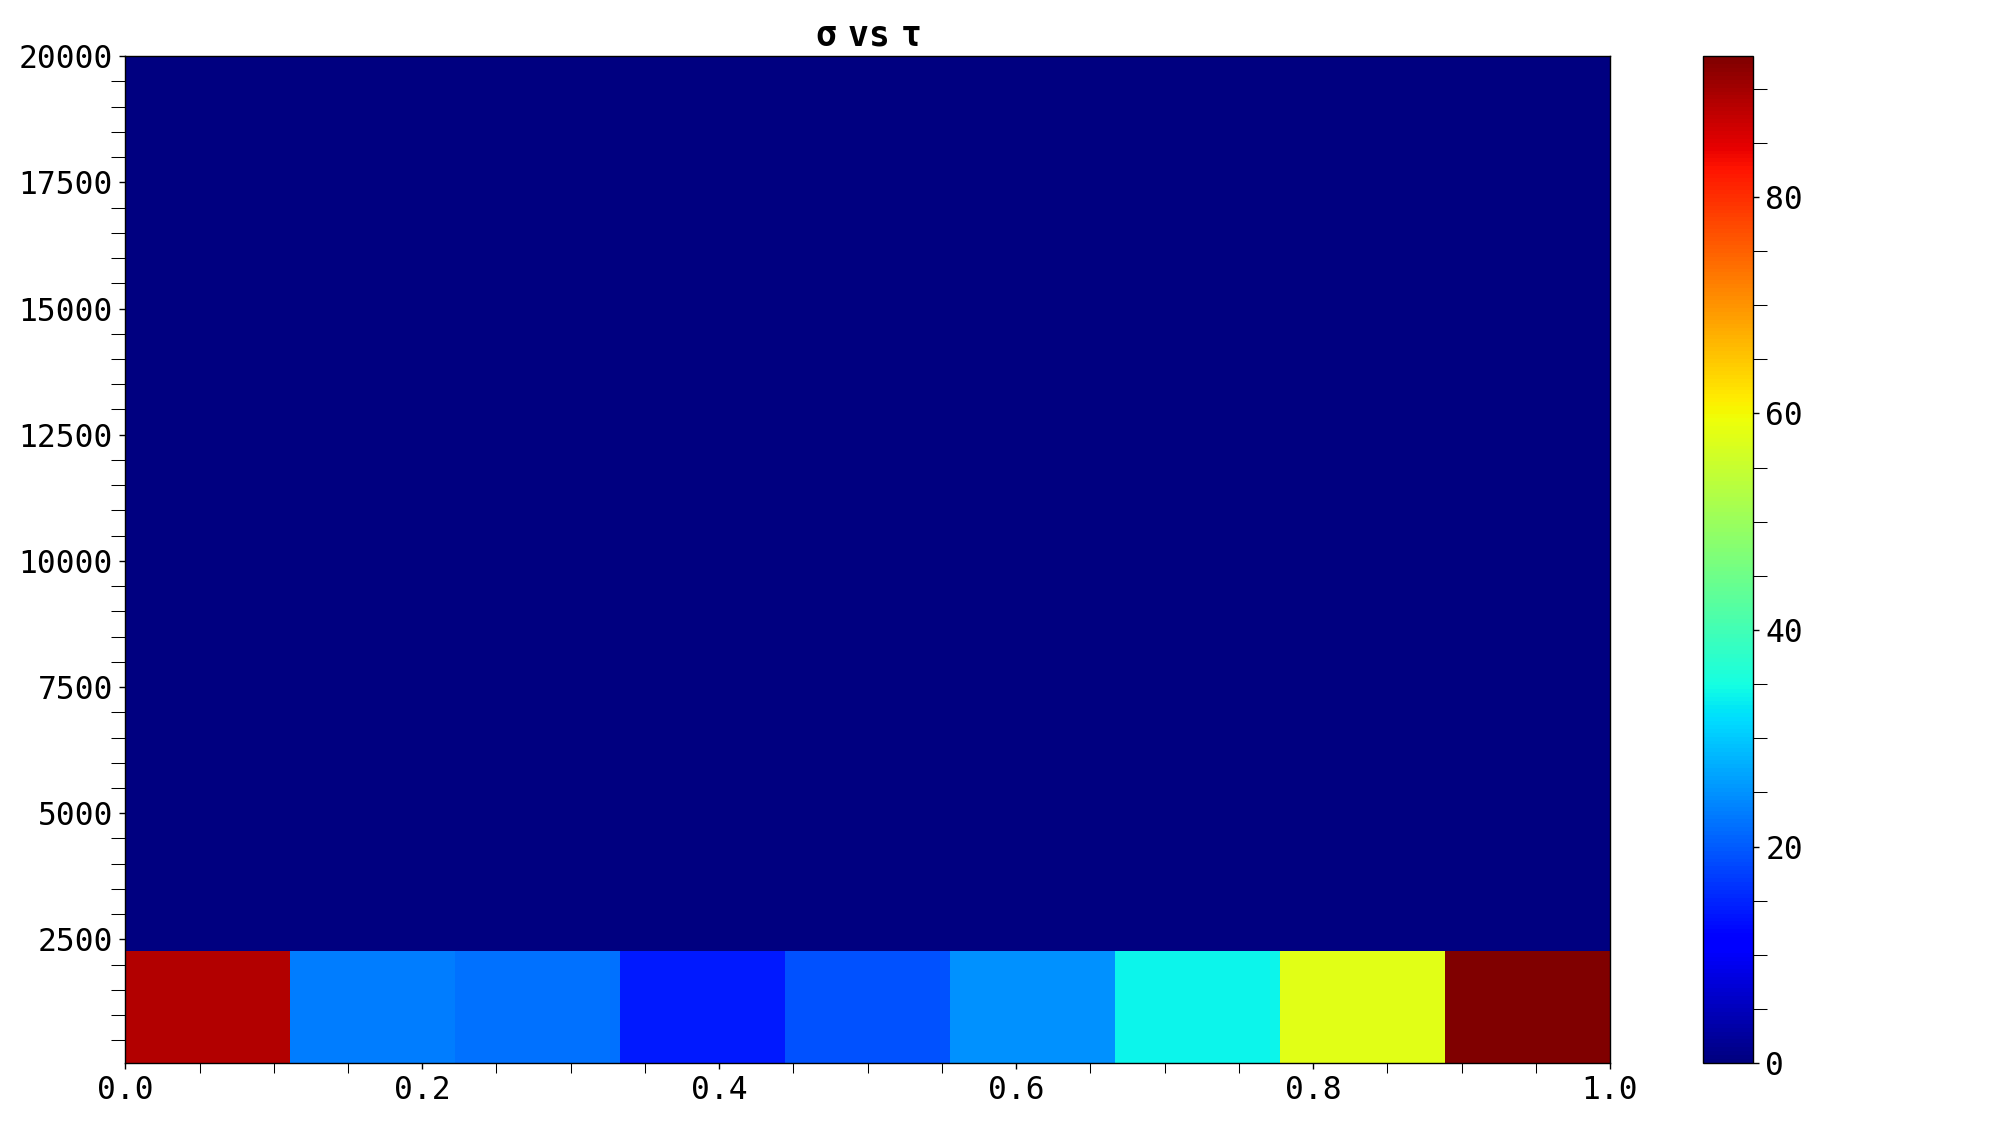

In [53]:
plt.close(6)
fig6, ax6 = plt.subplots()
hist_h, hist_xedges, hist_yedges, hist_im = ax6.hist2d(param_dict[ch_x]['sigma'], \
                    param_dict[ch_x]['tau'], bins = [np.linspace(0.0, 1.0, 10), np.linspace(50e0, 20e3, 10)] , \
                        cmap='jet')
fig6.colorbar(hist_im)
ax6.set_title('$\\sigma \ vs \ \\tau $');

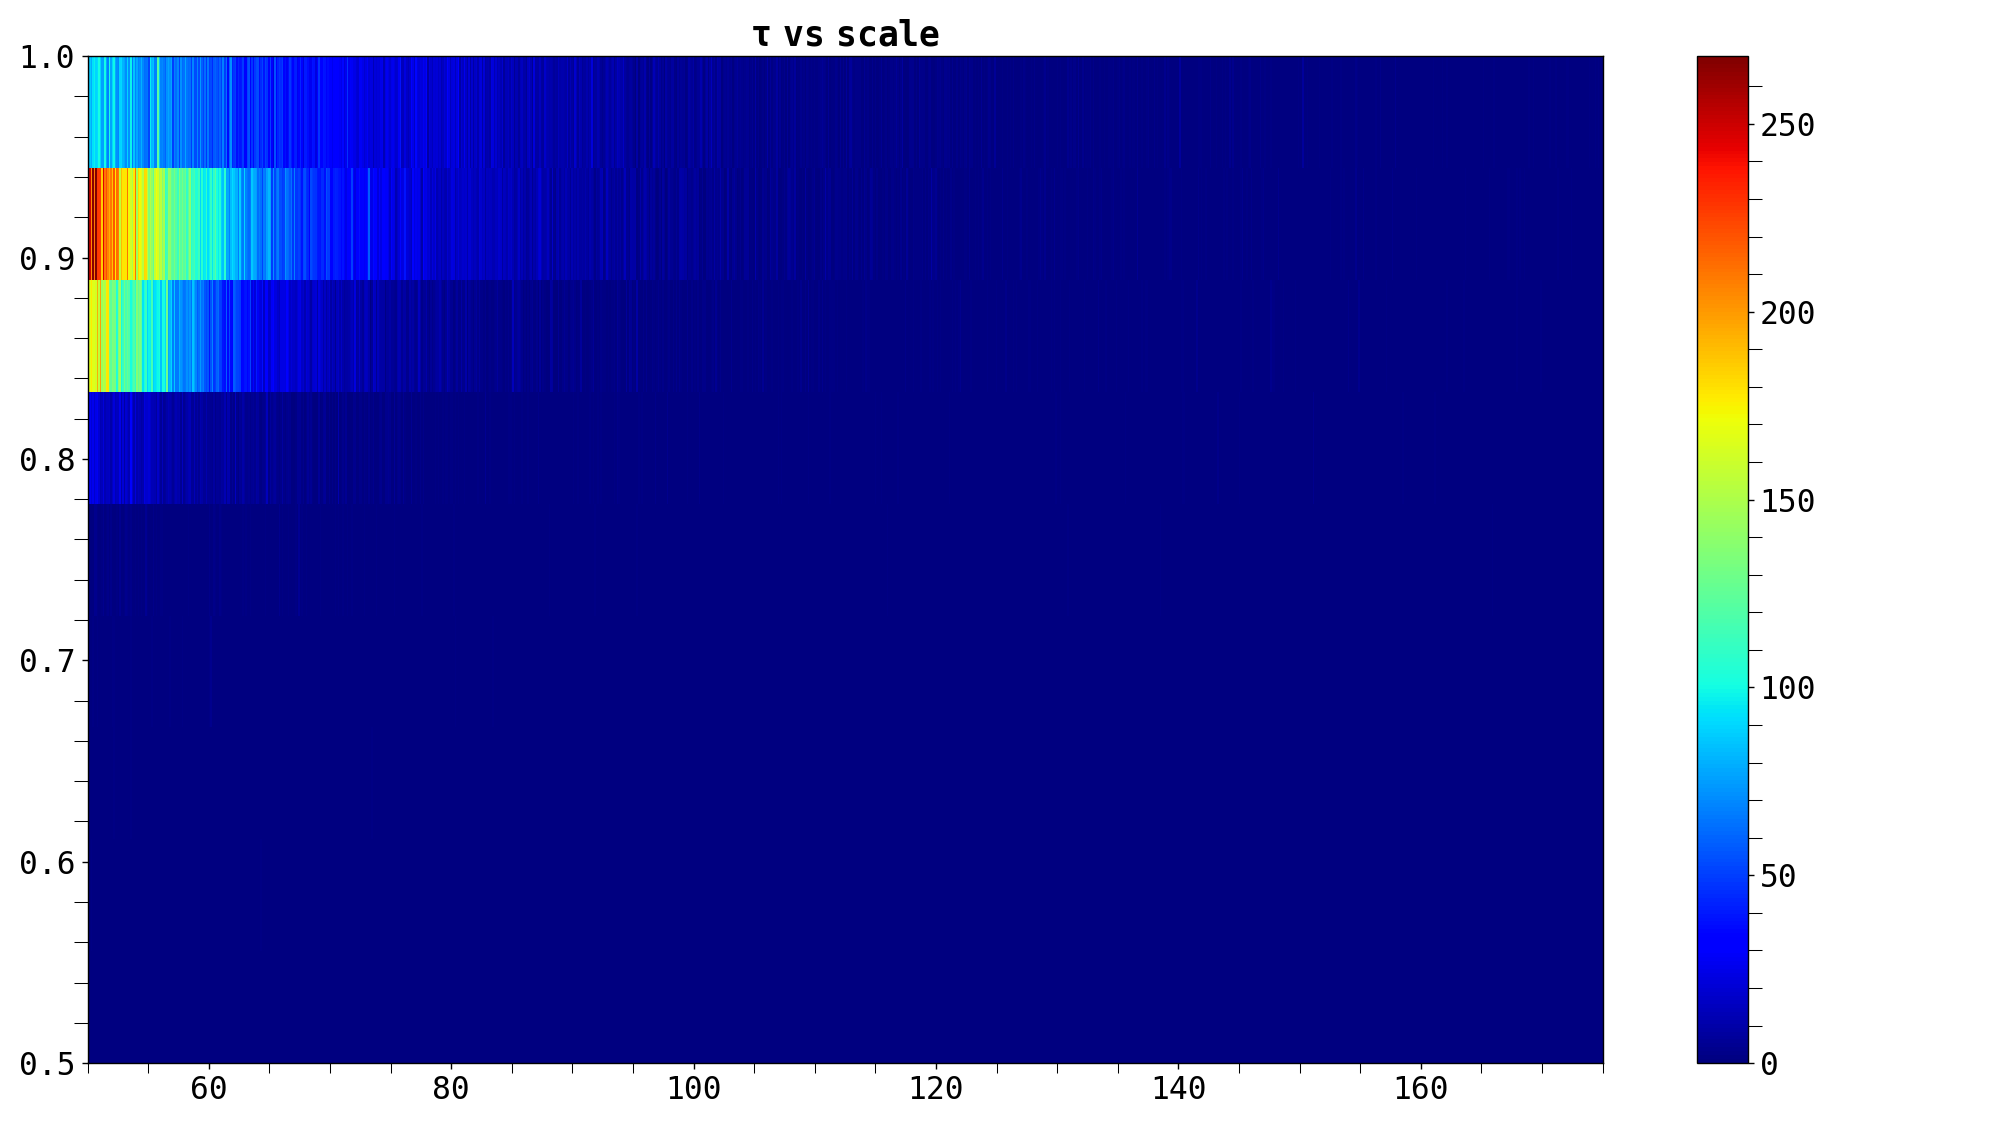

In [54]:
plt.close(7)
fig7, ax7 = plt.subplots()
hist_h, hist_xedges, hist_yedges, hist_im = ax7.hist2d(param_dict[ch_x]['tau'], \
                    param_dict[ch_x]['scale'], bins = [np.linspace(50, 175, 1000), np.linspace(0.5, 1.0, 10)], \
                    cmap='jet')
fig7.colorbar(hist_im)
ax7.set_title('$\\tau \ vs \ scale $');

# 9. <a id='toc9_'></a>[Cuts:  rectangular cut](#toc0_)

<span style='color:green'> List of events to be removed</span>

In [55]:
### list of events which contribute to red window for Ch2
internal_points = []
for fit_index in fit_catalogue[ch_x].index.values:
    loop_fit_param = fit_catalogue[ch_x]['fit_param'].loc[fit_index]
    param_point = (loop_fit_param[3], loop_fit_param[1]) # scale, sigma
    transformed_interior_point = red_win.get_data_transform().transform(param_point)
    if red_win.contains_point(transformed_interior_point, radius=0):
        internal_points.append(fit_index)

<span style = 'color:green'> Exploratory Analysis on red window: </span>

In [56]:
internal_points;

In [57]:
all_indices = fit_catalogue[ch_x].index.values

In [58]:
all_indices[1000] in internal_points

False

In [ ]:
internal_points[215:]

[1902,
 1911,
 1917,
 1922,
 1959,
 1968,
 1973,
 1980,
 1992,
 1997,
 2015,
 2029,
 2036,
 2069,
 2071,
 2084,
 2101,
 2106,
 2107,
 2114,
 2115,
 2130,
 2133,
 2136,
 2147,
 2155,
 2160,
 2162,
 2167,
 2177,
 2182,
 2211,
 2225,
 2249,
 2253,
 2264,
 2265,
 2270,
 2278,
 2293,
 2296,
 2301,
 2305,
 2309,
 2312,
 2316,
 2317,
 2340,
 2347,
 2352,
 2358,
 2384,
 2395,
 2404,
 2410,
 2421,
 2434,
 2435,
 2438,
 2440,
 2442,
 2449,
 2452,
 2460,
 2471,
 2480,
 2511,
 2524,
 2527,
 2528,
 2540,
 2567,
 2568,
 2573,
 2583,
 2593,
 2614,
 2621,
 2645,
 2667,
 2683,
 2686,
 2691,
 2722,
 2729,
 2734,
 2744,
 2746,
 2751,
 2759,
 2765,
 2783,
 2785,
 2798,
 2822,
 2823,
 2831,
 2834,
 2840,
 2846,
 2852,
 2870,
 2886,
 2898,
 2907,
 2909,
 2914,
 2917,
 2924,
 2937,
 2942,
 2944,
 2951,
 2958,
 2959,
 3010,
 3014,
 3016,
 3020,
 3021,
 3022,
 3029,
 3031,
 3036,
 3052,
 3063,
 3069,
 3082,
 3084,
 3086,
 3090,
 3091,
 3097,
 3105,
 3108,
 3115,
 3116,
 3123,
 3132,
 3134,
 3143,
 3151,
 3165,

In [60]:
# for fit_index in fit_catalogue[ch_x].index.values:
#     fit_param = fit_catalogue[ch_x]['fit_param'].iloc[fit_index]
#     if fit_index > 100 and fit_param[1] > 2.5 and fit_param[1] < 2.65 and fit_param[3] > 0.97 and fit_param[3] < 0.99:
#         print(fit_index)
#         print(f'sigma: { fit_param[1]}')
#         print(f'alpha: { fit_param[3]}')

In [61]:
# for fit_index in fit_catalogue[ch_x].index.values:
#     fit_param = fit_catalogue[ch_x]['fit_param'].iloc[fit_index]
#     if fit_index > 100 and fit_param[1] > 2.02 and fit_param[1] < 2.12 and fit_param[3] > 0.888 and fit_param[3] < 0.890:
#         print(fit_index)
#         print(f'sigma: { fit_param[1]}')
#         print(f'alpha: { fit_param[3]}')

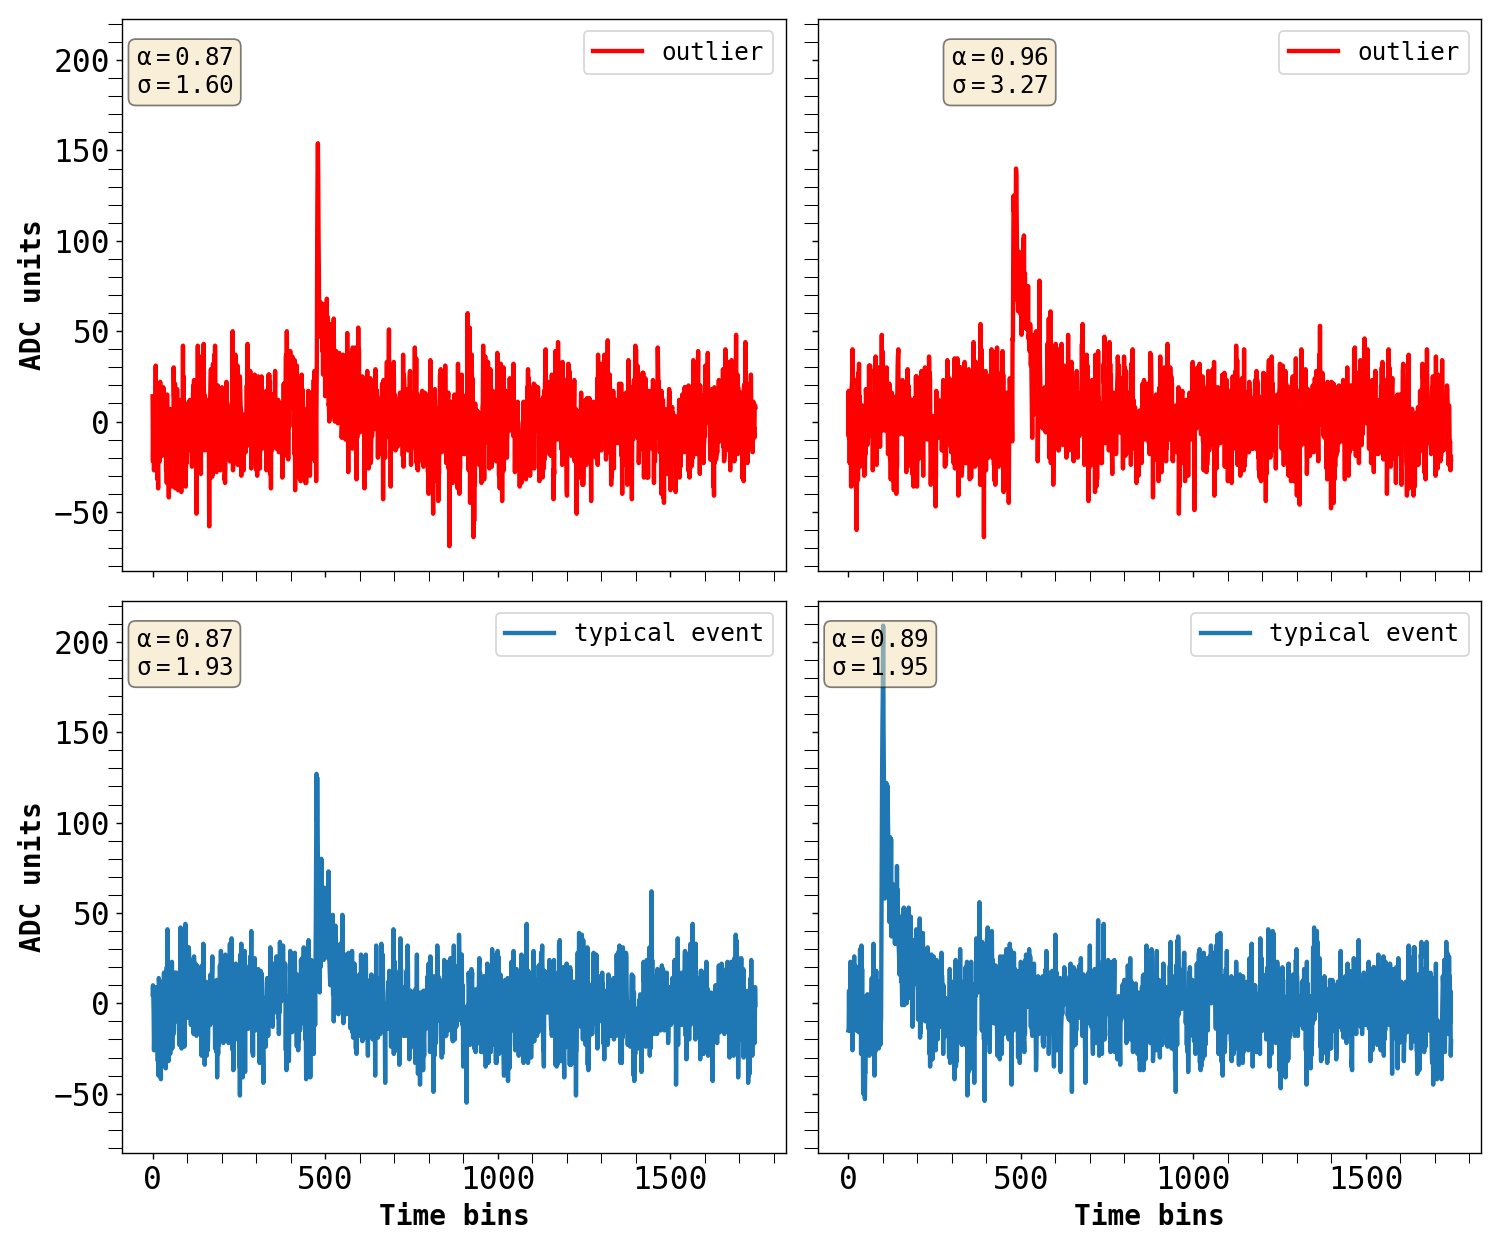

In [62]:
pnt1 = 169 #111
pnt2 = 1023 #119
pnt3 = 263 #
pnt4 = 302 # 302

fig555, ax555 = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey = True) #12, 10
# selected_internal_wf = fit_catalogue[ch_x]['wf_raw'][internal_points[500]]
selected_internal_wf = fit_catalogue[ch_x]['wf_raw'][all_indices[pnt1]] # 78 111
ax555[0][0].plot(selected_internal_wf, label = 'outlier', color='red')
# ax555[0][0].set_title(f"{ch_x} waveform from within red window")

# selected_internal_wf = fit_catalogue[ch_x]['wf_raw'][internal_points[997]]
selected_internal_wf = fit_catalogue[ch_x]['wf_raw'][all_indices[pnt2]] #946 1075 26 42 67 77 94 119
ax555[0][1].plot(selected_internal_wf, label = 'outlier', color='red')
# ax555[0][1].set_title(f"{ch_x} waveform from within red window")

selected_external_wf = fit_catalogue[ch_x]['wf_raw'][all_indices[pnt3]] # 260
ax555[1][0].plot(selected_external_wf, label = 'typical event')
# ax555[1][0].set_title(f"{ch_x} waveform from outside red window")

selected_external_wf = fit_catalogue[ch_x]['wf_raw'][all_indices[pnt4]] # 262
ax555[1][1].plot(selected_external_wf, label = 'typical event')
# ax555[1][1].set_title(f"{ch_x} waveform from outside red window")

ax555[0][0].legend()
ax555[0][1].legend()
ax555[1][0].legend()
ax555[1][1].legend()

# fig555.suptitle("comparison of waveforms from within and outside rectangular window")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.0)
# fig555.tight_layout()
# text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['t0'])}", \
#                                        loc='upper right')
# ax555.add_artist(text_in_box)
ax555[0][0].set_ylabel('ADC units')
ax555[1][0].set_xlabel('Time bins')
ax555[1][0].set_ylabel('ADC units')
ax555[1][1].set_xlabel('Time bins')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
txtstr = r"$\alpha =" f"{param_dict[ch_x]['scale'][pnt1]:.2F}$" + "\n" + r"$\sigma =" f"{param_dict[ch_x]['sigma'][pnt1]:.2F}$"
ax555[0][0].text(0.02, 0.95, txtstr, transform=ax555[0][0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
txtstr = r"$\alpha =" f"{param_dict[ch_x]['scale'][pnt2]:.2F}$" + "\n" + r"$\sigma =" f"{param_dict[ch_x]['sigma'][pnt2]:.2F}$"
ax555[0][1].text(0.2, 0.95, txtstr, transform=ax555[0][1].transAxes, fontsize=14, verticalalignment='top', bbox=props)
txtstr = r"$\alpha =" f"{param_dict[ch_x]['scale'][pnt3]:.2F}$" + "\n" + r"$\sigma =" f"{param_dict[ch_x]['sigma'][pnt3]:.2F}$"
ax555[1][0].text(0.02, 0.95, txtstr, transform=ax555[1][0].transAxes, fontsize=14, verticalalignment='top', bbox=props)
txtstr = r"$\alpha =" f"{param_dict[ch_x]['scale'][pnt4]:.2F}$" + "\n" + r"$\sigma =" f"{param_dict[ch_x]['sigma'][pnt4]:.2F}$"
ax555[1][1].text(0.02, 0.95, txtstr, transform=ax555[1][1].transAxes, fontsize=14, verticalalignment='top', bbox=props)
fig555.savefig('../plots/ch2_alphVSsigma_outliers.png')

<span style='color:green;font-size:32pt'> applying cut </span>

In [63]:
# fit_catalogue[ch_x] = fit_catalogue[ch_x].drop(index = internal_points)

<span style='color:green'> extracting param_dict out of DataFrames for all channels </span>

In [64]:
param_dict_cut = {}
for ch_index in ch_str_ls:
# for ch_x in ['ch2']: #ch_str_ls:
    t0_ls = []
    sigma_ls = []
    tau_ls = []
    scale_ls = []
    fit_param_x = {}
    for loop_index in fit_catalogue[ch_index].index.values:
        loop_fit_param = fit_catalogue[ch_index].loc[loop_index]['fit_param']
        t0_ls.append(loop_fit_param[0])
        sigma_ls.append(loop_fit_param[1])
        tau_ls.append(loop_fit_param[2])
        scale_ls.append(loop_fit_param[3])
    fit_param_x['t0'] = t0_ls
    fit_param_x['sigma'] = sigma_ls
    fit_param_x['tau'] = tau_ls
    fit_param_x['scale'] = scale_ls
    param_dict_cut[ch_index] = fit_param_x

In [65]:
## selected_channel = input("enter channel number") # input by user
## ch_x = ch_str_ls[int(selected_channel)]
## ch_x = 'ch2'

Text(0, 0.5, 'counts')

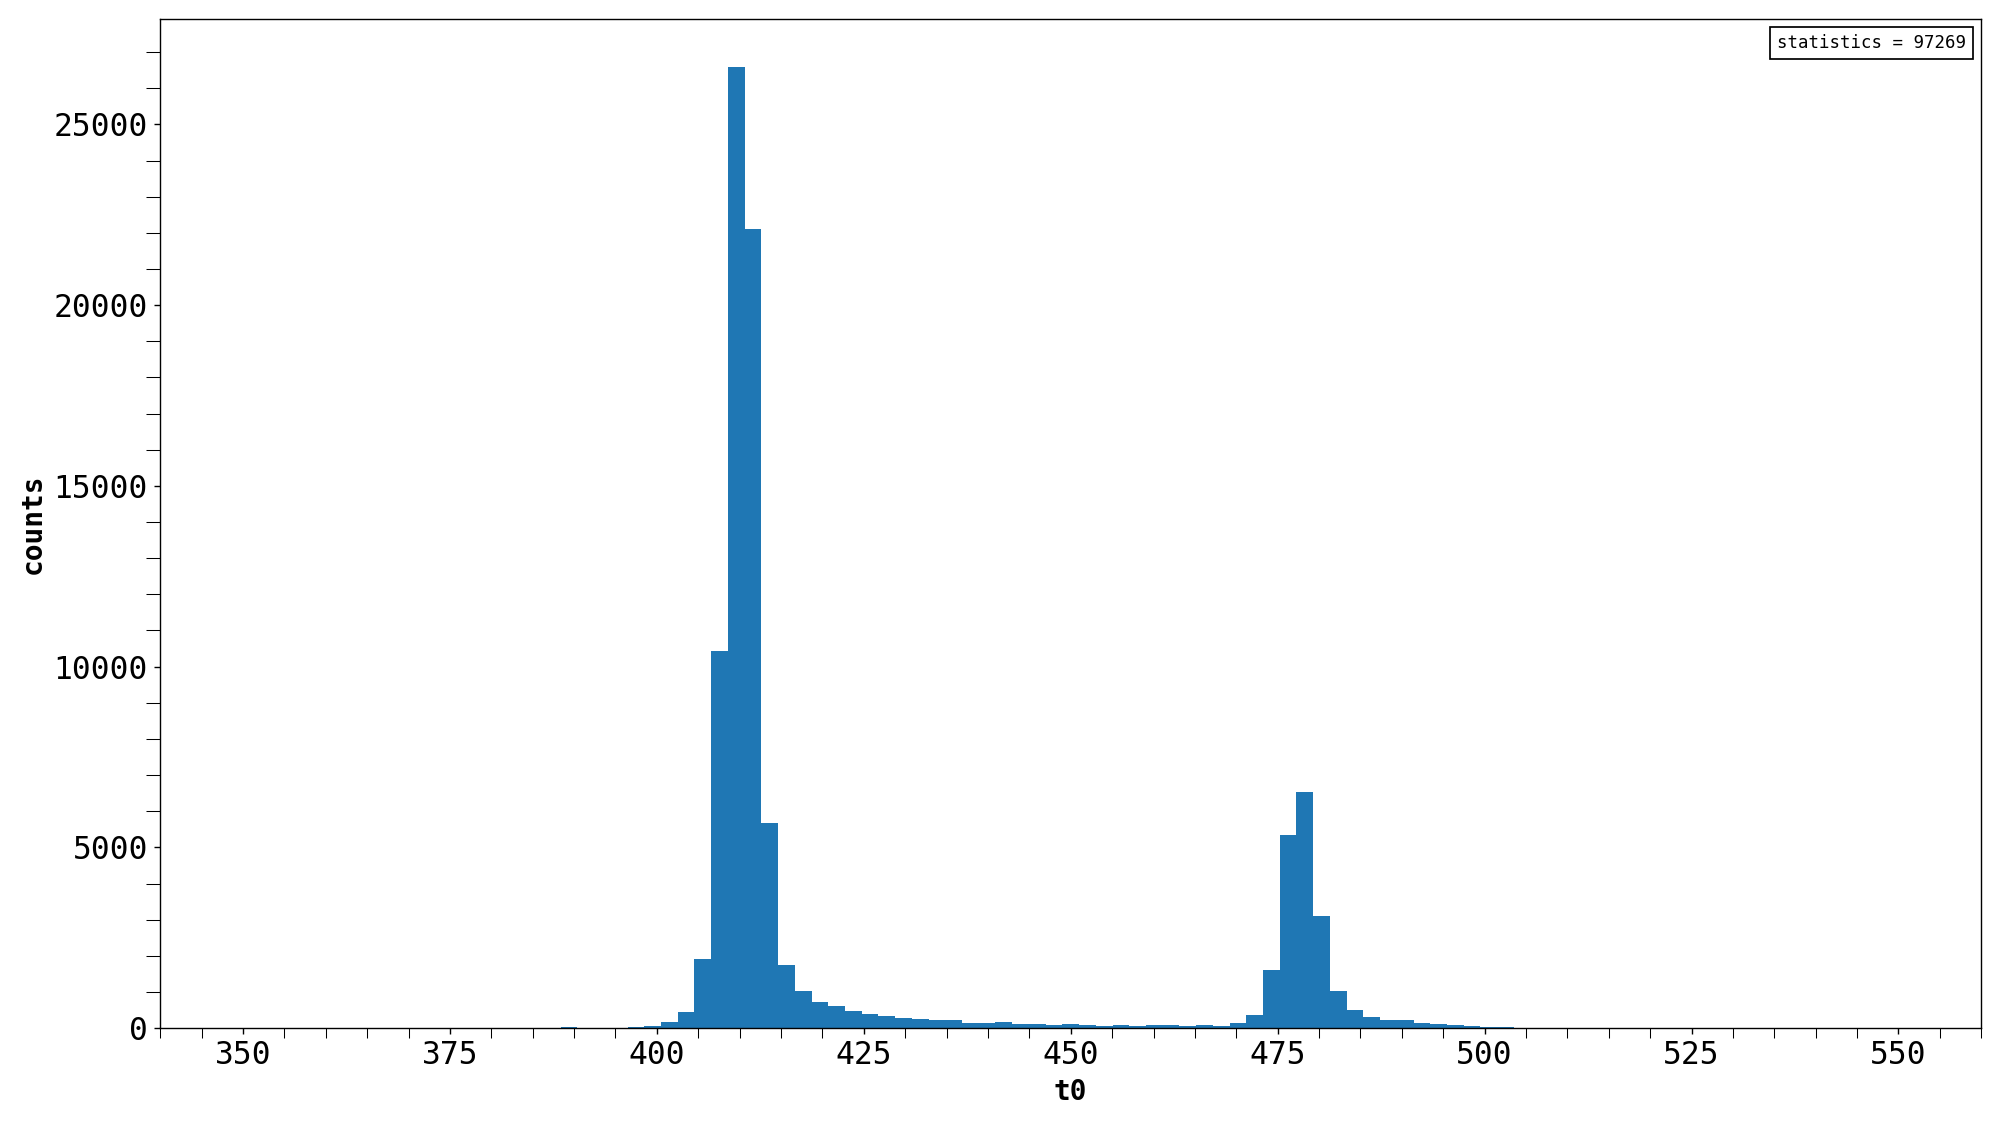

In [66]:
plt.close(22)
fig22, ax22 = plt.subplots()
text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['t0'])}", \
                                       loc='upper right')
ax22.add_artist(text_in_box)
ax22.hist(param_dict_cut[ch_x]['t0'], bins = np.linspace(350, 550, 100))
# ax22.set_title(f"{ch_x} t0: patch removed")
ax22.set_xlabel('t0')
ax22.set_ylabel('counts')

## 9.1. <a id='toc9_1_'></a>[$ \sigma$](#toc0_)

(0.0, 1200.0)

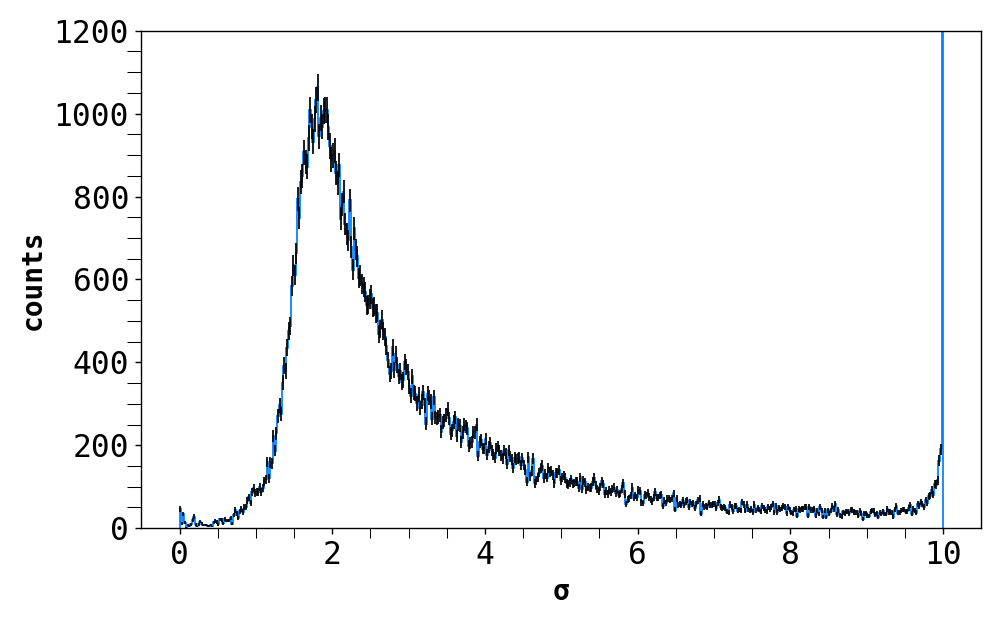

In [67]:
plt.close(23)
# fig23, ax23 = plt.subplots(figsize=(10, 8))
fig23, ax23 = plt.subplots(figsize=(8, 5))

# hist_content, hist_edges, _hist_obj= ax23.hist(param_dict_cut[ch_x]['sigma'], bins=200, color='#007FFF', histtype='step', label='$\\sigma$') #, bins= np.linspace(1.0, 6.0, 10))
hist_content, hist_edges, _hist_obj= ax23.hist(param_dict_cut[ch_x]['sigma'], bins=500, color='#007FFF', histtype='step', label='$\\sigma$') #, bins= np.linspace(1.0, 6.0, 10))

## error bars
hist_centers = []
for i in range(hist_edges.shape[0]):
    center_variable = np.mean(hist_edges[i:i+2])
    hist_centers.append(center_variable)

hist_centers = np.array(hist_centers)

ax23.errorbar(hist_centers[:hist_content.shape[0]], hist_content, \
              yerr = np.sqrt(hist_content), elinewidth=1.0, linestyle='none', ecolor='black', label='Error bars') #'#ADFF2F'

# text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['sigma'])}", \
                                    #    loc='lower right')
# ax23.add_artist(text_in_box)
# ax23.set_title(f"{ch_x} $\\sigma$: patch removed")
ax23.set_xlabel('$\\sigma$')
ax23.set_ylabel('counts')
ax23.set_ylim(0, 1200) # temp
# ax23.legend(loc='upper center').get_frame().set_alpha(0.4)

### 9.1.1. <a id='toc9_1_1_'></a>[fitting](#toc0_)

In [68]:
np.where(hist_edges <= 1.99)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

In [ ]:
# x_range # ch1 & ch2
# x_range = [range(24, 40), range(30, 49), range(30, 49)][selected_channel] ##ch0
# x_range = [range(24, 40), range(24, 41), range(30, 49)][selected_channel]
x_range = [range(75, 120), range(24, 41), range(30, 49)][selected_channel] # 500 bins

p0_input = [2, 0.45, 500]
bounds_input = ([1.50, 0.0, 0.0], [2.15, 1.0, np.inf])

fitted_parameters_sigma, _pcov = curve_fit(f_gauss, 
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input, 
                            sigma = np.sqrt(hist_content[x_range]),
                            absolute_sigma=True,
                            bounds = bounds_input,
                            )

ax23.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters_sigma), \
          color='#DC143C', label='fit')

ax23.legend(loc='upper center').get_frame().set_alpha(0.4)

chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters_sigma), fitted_parameters_sigma
    )

print(f'chisqr_value: {chisqr_value}')
text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['sigma'])} \n$\\chi^{2}/\\nu$ = {chisqr_value:.2f}  \n$\\mu$ = {fitted_parameters_sigma[0]:.3f} \nCOM = {calc_COM(hist_content, hist_edges):.3f}", \
                            loc='upper right')

text_in_box.patch.set_alpha(0.1)

ax23.add_artist(text_in_box)
# fig23.savefig(f'../plots/{ch_x}_sigma_hist.png')

fitted_parameters_sigma

chisqr_value: 3.6357570042148626


array([     1.862,     0.4726,       1148])

## 9.2. <a id='toc9_2_'></a>[$\tau$](#toc0_)

Text(0.5, 0, '$\\tau$')

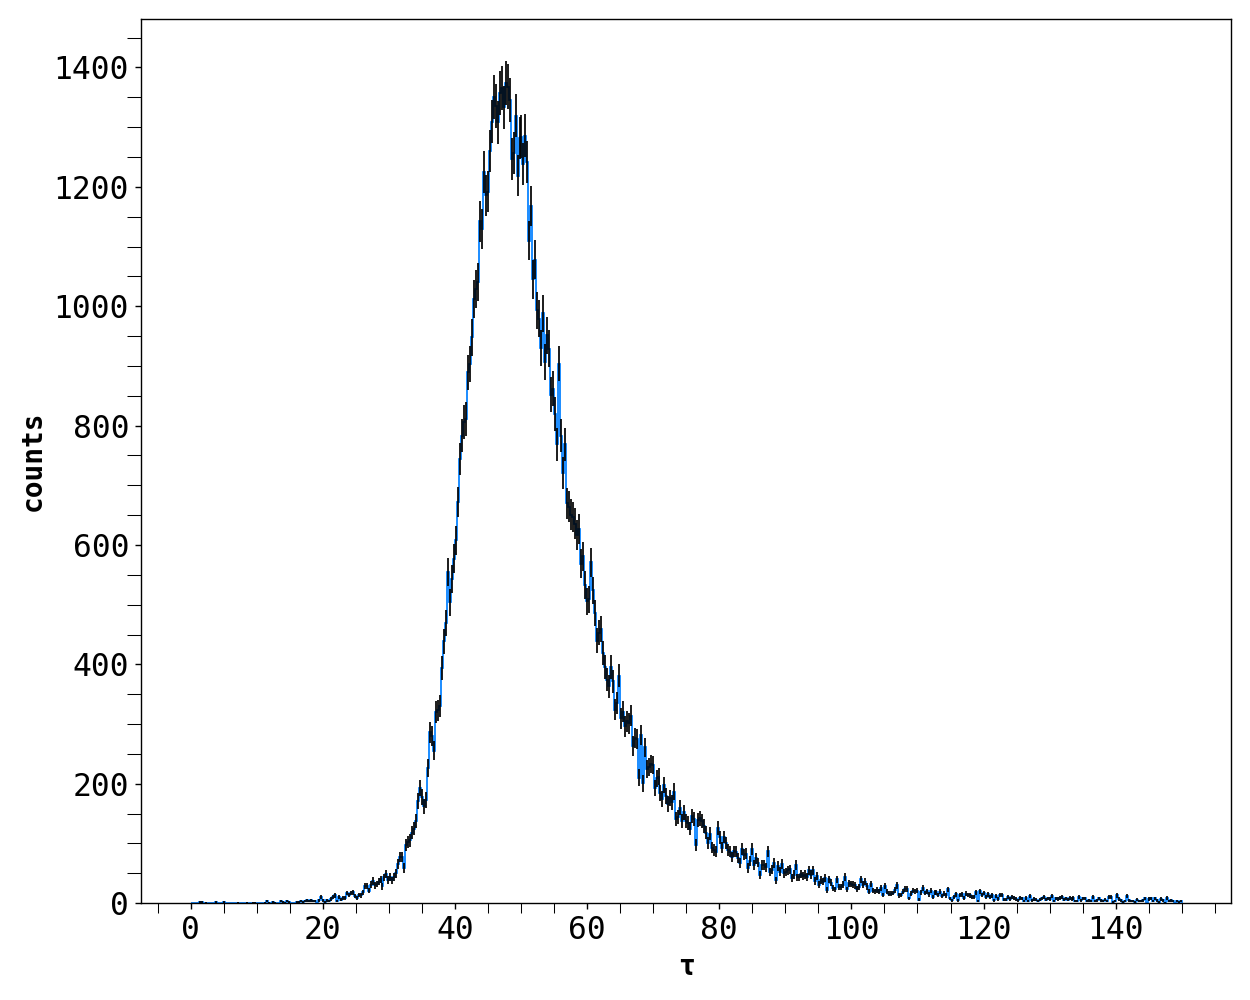

In [70]:
# ch_x = 'ch2'
plt.close(24)
fig24, ax24 = plt.subplots(figsize=(10, 8))
# hist_content, hist_edges, _hist_obj = ax24.hist(param_dict_cut[ch_x]['tau'], bins= np.linspace(0.0, 150.0, 250), color='#007FFF', histtype='step', label = '$\\tau$')
hist_content, hist_edges, _hist_obj = ax24.hist(param_dict_cut[ch_x]['tau'], bins= np.linspace(0.0, 150.0, 500), color='#007FFF', histtype='step', label = '$\\tau$')
# text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['tau'])}", \
#                                        loc='upper right')
# ax24.add_artist(text_in_box)
# ax24.set_title(f"{ch_x} $\\tau$: patch removed")

##error bars
hist_centers = []
for i in range(hist_edges.shape[0]):
    center_variable = np.mean(hist_edges[i:i+2])
    hist_centers.append(center_variable)

hist_centers = np.array(hist_centers)

ax24.errorbar(hist_centers[:hist_content.shape[0]], hist_content, yerr = np.sqrt(hist_content), elinewidth=1.0, linestyle='none', ecolor='black', label='Error bars')#'#ADFF2F'

ax24.set_ylabel('counts')
ax24.set_xlabel('$\\tau$')

### 9.2.1. <a id='toc9_2_1_'></a>[fitting](#toc0_)

In [71]:
# hist_edges[60]
hist_edges[150] # 500 bins

45.09018036072145

In [72]:
# x_range = range(58, 91) # ch0,1,2
# x_range = range(58, 73) # ch0 # needs to be updated does NOT cover mean position 
# x_range = range(58, 79) # new
# x_range = range(55, 90) #
# x_range = range(55, 95) # tau_distribution_fit_with_sigma
# x_range = range(55, 90) # tau_distribution_fit_without_sigma
# x_range = range(58, 85) # looks good chisqr = 1.78
#  x_range = range(58, 85) # best chisqr with errors: (59, 88)
x_range = range(65, 88) # also works chisqr = 1.79 
x_range = range(135, 180) # also works chisqr = 1.79 500 bins

# p0_input = [50.0, 9.0, 8000.0] # ch1 & ch2
p0_input = [50, 9, 10000] # ch0 new
# bounds_input = ([20.0, 0.05, 1.0], [60.0, 15.5, 10_000]) ## ch2
# bounds_input = ([20.0, 0.05, 1.0], [60.0, 15.5, np.inf]) ## ch0,1,2
bounds_input = ([20, 0.05, 1], [60, 15, np.inf]) ## ch0,1,2

fitted_parameters_tau, _pcov = curve_fit(f_gauss, \
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input, \
                            bounds = bounds_input, \
                            sigma = np.sqrt(hist_content[x_range]), \
                            absolute_sigma=True, \
                            # x_scale = [10, 1, 1000], \
                            method = 'trf', \
                            ## method = 'dogbox', \
                            )

### plotting
ax24.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters_tau), color='#DC143C', label='fit')
# ax24.legend(loc='upper right')
ax24.legend(loc='upper center').get_frame().set_alpha(0.4)

chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters_tau), fitted_parameters_tau
    )
print(f'chisqr value: {chisqr_value}')
text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['tau'])} \n$\\chi^{2}/\\nu$ = {chisqr_value:.2f} \n$\\mu$ = {fitted_parameters_tau[0]:.3f} \nCOM = {calc_COM(hist_content, hist_edges):.3f} ", \
                                       loc='upper right')

text_in_box.patch.set_alpha(0.1)
ax24.add_artist(text_in_box)
# fig24.savefig(f'../plots/{ch_x}_tau_hist.png')
fitted_parameters_tau

chisqr value: 1.5179046567571215


array([     47.66,      6.477,  2.183e+04])

### 9.2.2. <a id='toc9_2_2_'></a>[Fitting with iMinuit](#toc0_)
Only used for verifying scipy fitter

In [73]:
# import iminuit
# from iminuit.cost import LeastSquares
# from iminuit import Minuit

In [74]:
# least_squares = LeastSquares(x_values[58:91], hist_content[58:91], np.sqrt(hist_content[58:91]), f_gauss)
# # least_squares = LeastSquares(x_values, hist_content[:x_values.shape[0]], np.ones(x_values.shape[0]), f_gauss)

In [75]:
# m_obj = Minuit(least_squares, g_mean = 50.0, g_sigma = 9.5, g_k = 8000)

In [76]:
# m_obj.simplex()

In [77]:
# m_obj.migrad()

## 9.3. <a id='toc9_3_'></a>[scale](#toc0_)

(0.7, 1.0)

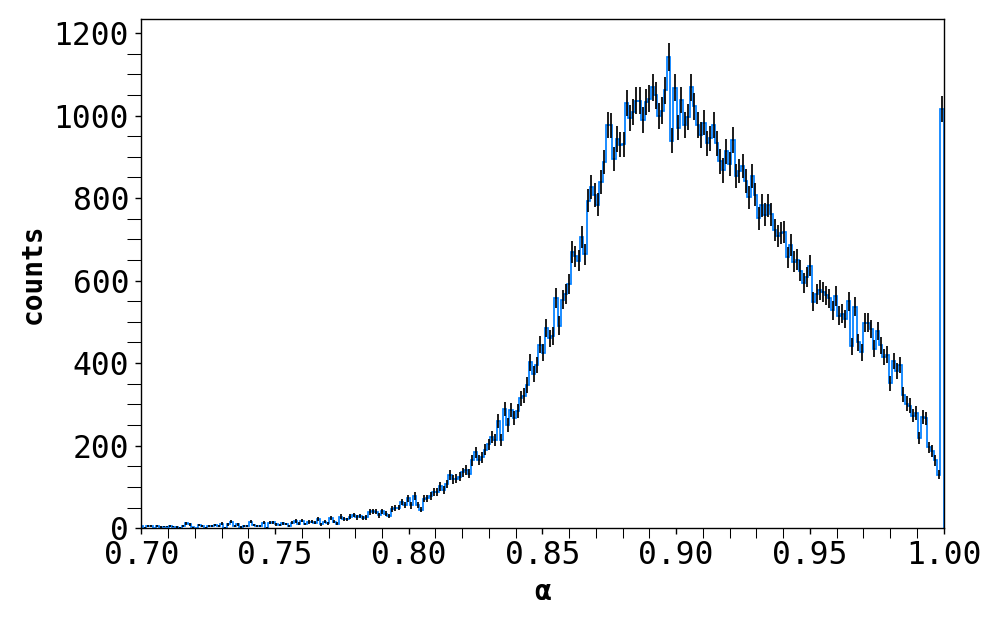

In [78]:
# ch_x = 'ch2'
plt.close(25)
# fig25, ax25 = plt.subplots(figsize=(10, 8))
fig25, ax25 = plt.subplots(figsize=(8, 5))
hist_content, hist_edges, _hist_obj = ax25.hist(param_dict_cut[ch_x]['scale'], \
                                                bins= np.linspace(0.4, 1.0, 500), color='#007FFF', histtype='step', label='$\\alpha$')
                                                # bins= np.linspace(0.4, 1.0, 200), color='#007FFF', histtype='step', label='$\\alpha$')
##error bars
hist_centers = []
for i in range(hist_edges.shape[0]):
    center_variable = np.mean(hist_edges[i:i+2])
    hist_centers.append(center_variable)

hist_centers = np.array(hist_centers)

ax25.errorbar(hist_centers[:hist_content.shape[0]], hist_content, \
              yerr = np.sqrt(hist_content), elinewidth=1.0, linestyle='none', ecolor='black', label='Error bars') ##ADFF2F

# text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['scale'])}", \
#                                        loc='upper left')
# ax25.add_artist(text_in_box)
# ax25.set_title(f"{ch_x} scale: patch removed")

ax25.set_ylabel('counts')
ax25.set_xlabel('$\\alpha$')
ax25.set_xlim(0.7, 1.0) # keep or remove?
# plt.close(25)
# fig25, ax25 = plt.subplots(figsize=(10, 8))
# hist_content, hist_edges, _hist_obj = ax25.hist(param_dict_cut[ch_x]['scale'], \
#                                                 bins= np.linspace(0.7, 1.0, 100), color='#007FFF', histtype='step', label='$\\alpha$')
# ax25.set_ylabel('counts')
# ax25.set_xlabel('$\\alpha$')

### 9.3.1. <a id='toc9_3_1_'></a>[fitting](#toc0_)

In [79]:
# hist_edges[np.where(hist_edges >= 0.9499)]
# np.where(hist_edges >= 0.9499)
hist_edges[375]

0.8509018036072145

In [ ]:
# x_range = [range(153, 172), range(130, 172), range(130, 172)][selected_channel] # range(130, 177) 160 165 # ch2
# x_range = [range(157, 169), range(138, 157), range(130, 172)][selected_channel]
# x_range = [range(385, 447), range(138, 157), range(130, 172)][selected_channel] # 500 bins only adjsuted for Ch0
x_range = [range(370, 445), range(138, 157), range(130, 172)][selected_channel] # 500 bins

## x_range = range(153, 172) # ch0
p0_input = [0.89, 0.09, 200.0]
bounds_input = ([0.8, 0.01, 1.0], [1.0, 1.0, 10_000])

fitted_parameters_scale, _pcov = curve_fit(f_gauss, \
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input, \
                            bounds = bounds_input, \
                            sigma = np.sqrt(hist_content[x_range]), \
                            absolute_sigma=True, \
                            # x_scale = [10, 1, 1000], \
                            method = 'trf', \
                            ## method = 'dogbox', \
                            )
# ##error bars
# hist_centers = []
# for i in range(hist_edges.shape[0]):
#     center_variable = np.mean(hist_edges[i:i+2])
#     hist_centers.append(center_variable)

# hist_centers = np.array(hist_centers)

# ax25.errorbar(hist_centers[:hist_content.shape[0]], hist_content, \
#               yerr = np.sqrt(hist_content), elinewidth=1.0, linestyle='none', ecolor='black', label='Error bars') ##ADFF2F
### plotting
ax25.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters_scale), \
          color='#DC143C', label='fit')
# ax25.axvline(x = 0.9026)
# ax25.legend(loc='lower left')
ax25.legend(loc='upper left').get_frame().set_alpha(0.4)

chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters_scale), fitted_parameters_scale
    )

print(f'chisqr_value: {chisqr_value}')
print(f'fitted_parameters_scale: {fitted_parameters_scale}')

text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['scale'])} \n$\\chi^{2}/\\nu$ = {chisqr_value:.2f} \n$\\mu$ = {fitted_parameters_scale[0]:.3f} \nCOM = {calc_COM(hist_content, hist_edges):.3f}", \
                                       loc='lower left')
text_in_box.patch.set_alpha(0.1)
ax25.add_artist(text_in_box)

# fig25.savefig(f'../plots/{ch_x}_alpha_hist.png')

chisqr_value: 2.796776767906017
fitted_parameters_scale: [    0.8988    0.03808      100.6]



2d parameter space 

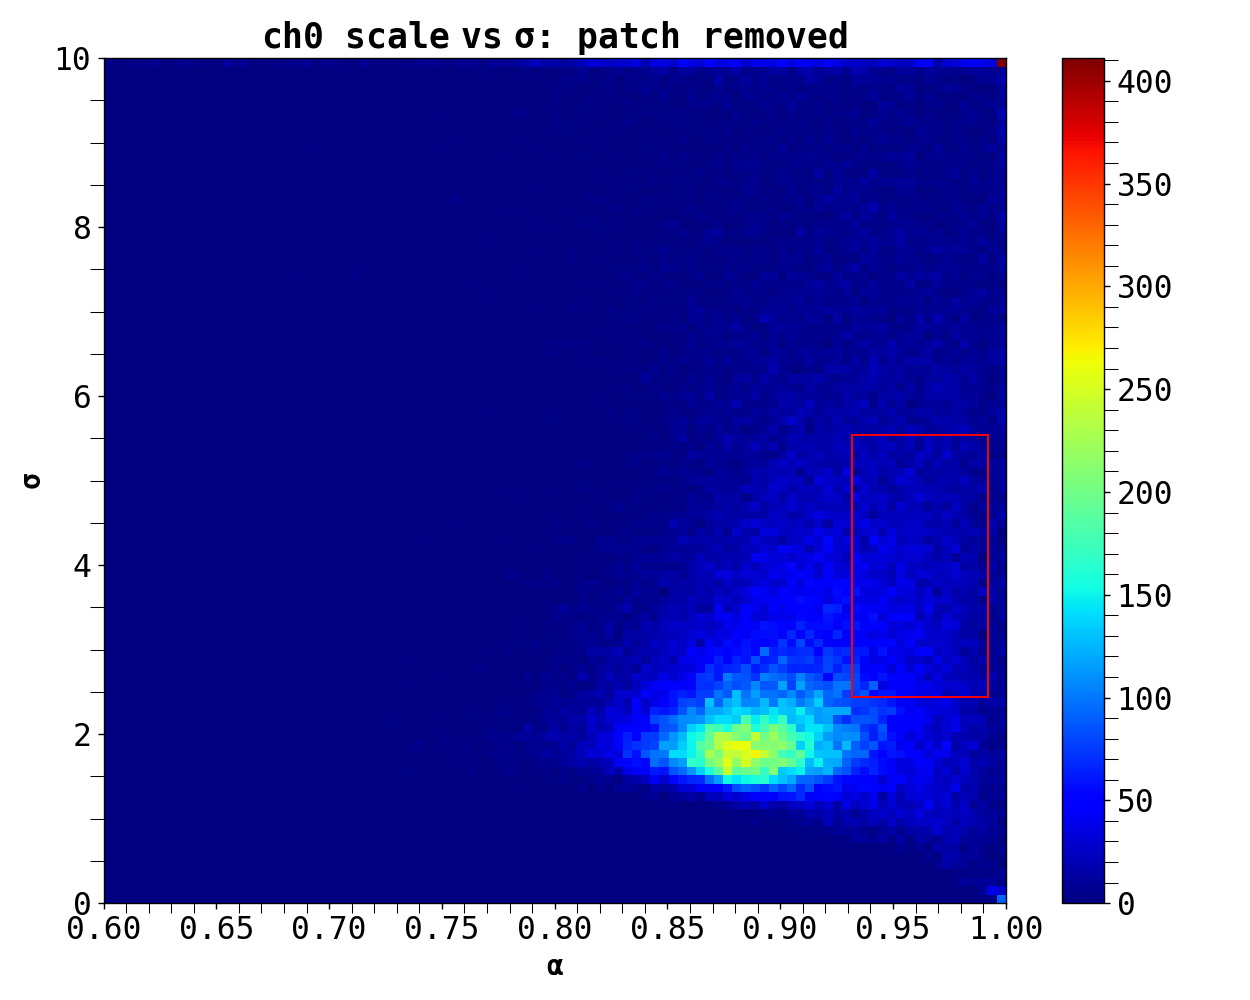

In [81]:
# ch_x = 'ch2'
plt.close(26)
fig26, ax26 = plt.subplots(figsize=(10, 8))
red_win = patches.Rectangle((0.932, 2.44), 0.06, 3.10, linewidth=1.1, edgecolor='r', facecolor='none')

hist_h, hist_xedges, hist_yedges, hist_im = ax26.hist2d(param_dict_cut[ch_x]['scale'], param_dict_cut[ch_x]['sigma'], \
           bins = [np.linspace(0.6, 1.0, 100), np.linspace(0., 10., 100)], cmap='jet')
ax26.add_patch(red_win)
ax26.set_xlabel('$\\alpha$')
ax26.set_ylabel('$\sigma$')
fig26.colorbar(hist_im)
ax26.set_title(f"{ch_x} $scale\ vs \ \\sigma$: patch removed");

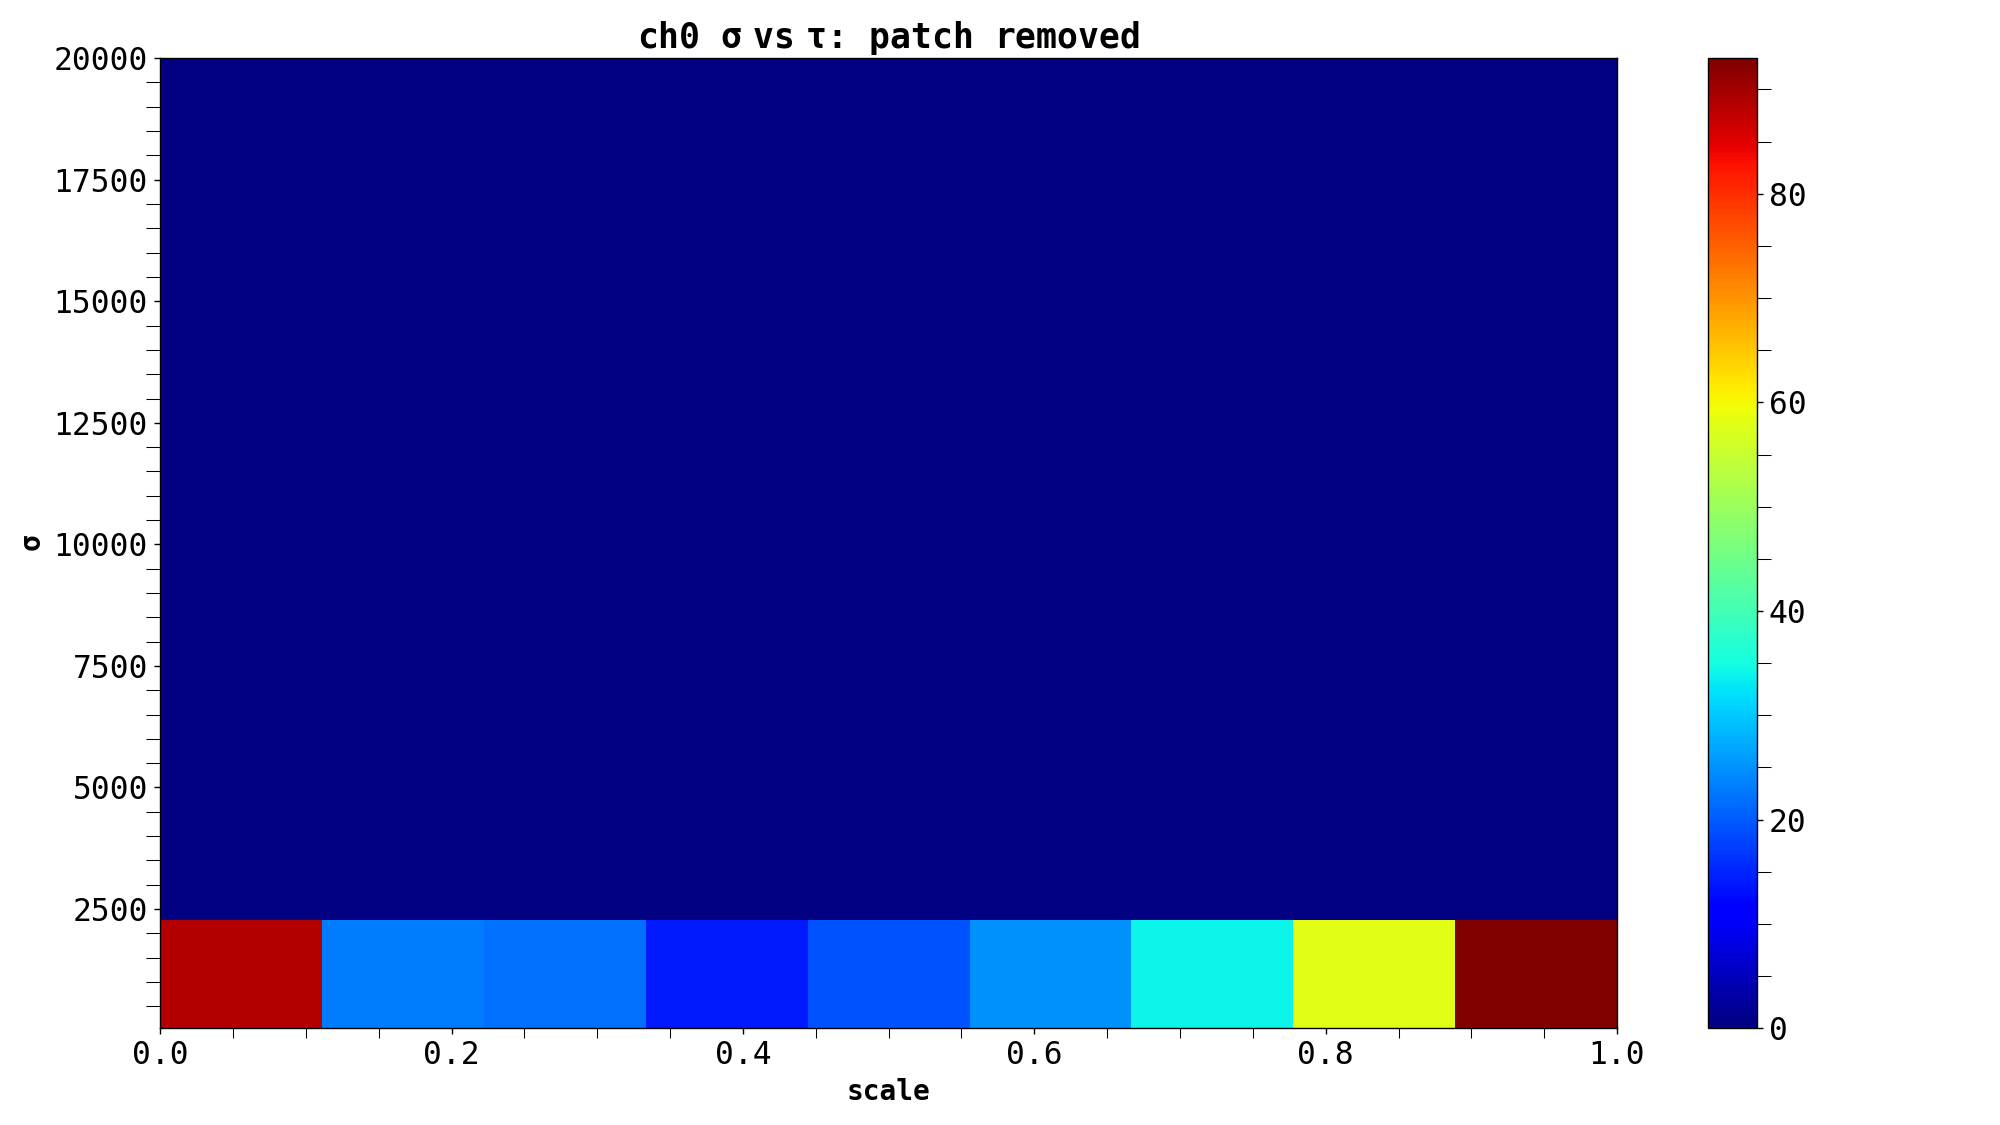

In [82]:
# ch_x = 'ch2'
plt.close(27)
fig27, ax27 = plt.subplots()
hist_h, hist_xedges, hist_yedges, hist_im = ax27.hist2d(param_dict_cut[ch_x]['sigma'], param_dict_cut[ch_x]['tau'], \
           bins = [np.linspace(0.0, 1.0, 10), np.linspace(50e0, 20e3, 10)] , cmap='jet')
ax27.set_xlabel('scale')
ax27.set_ylabel('$\sigma$')
fig27.colorbar(hist_im)
ax27.set_title(f"{ch_x} $\\sigma \ vs \ \\tau $: patch removed");

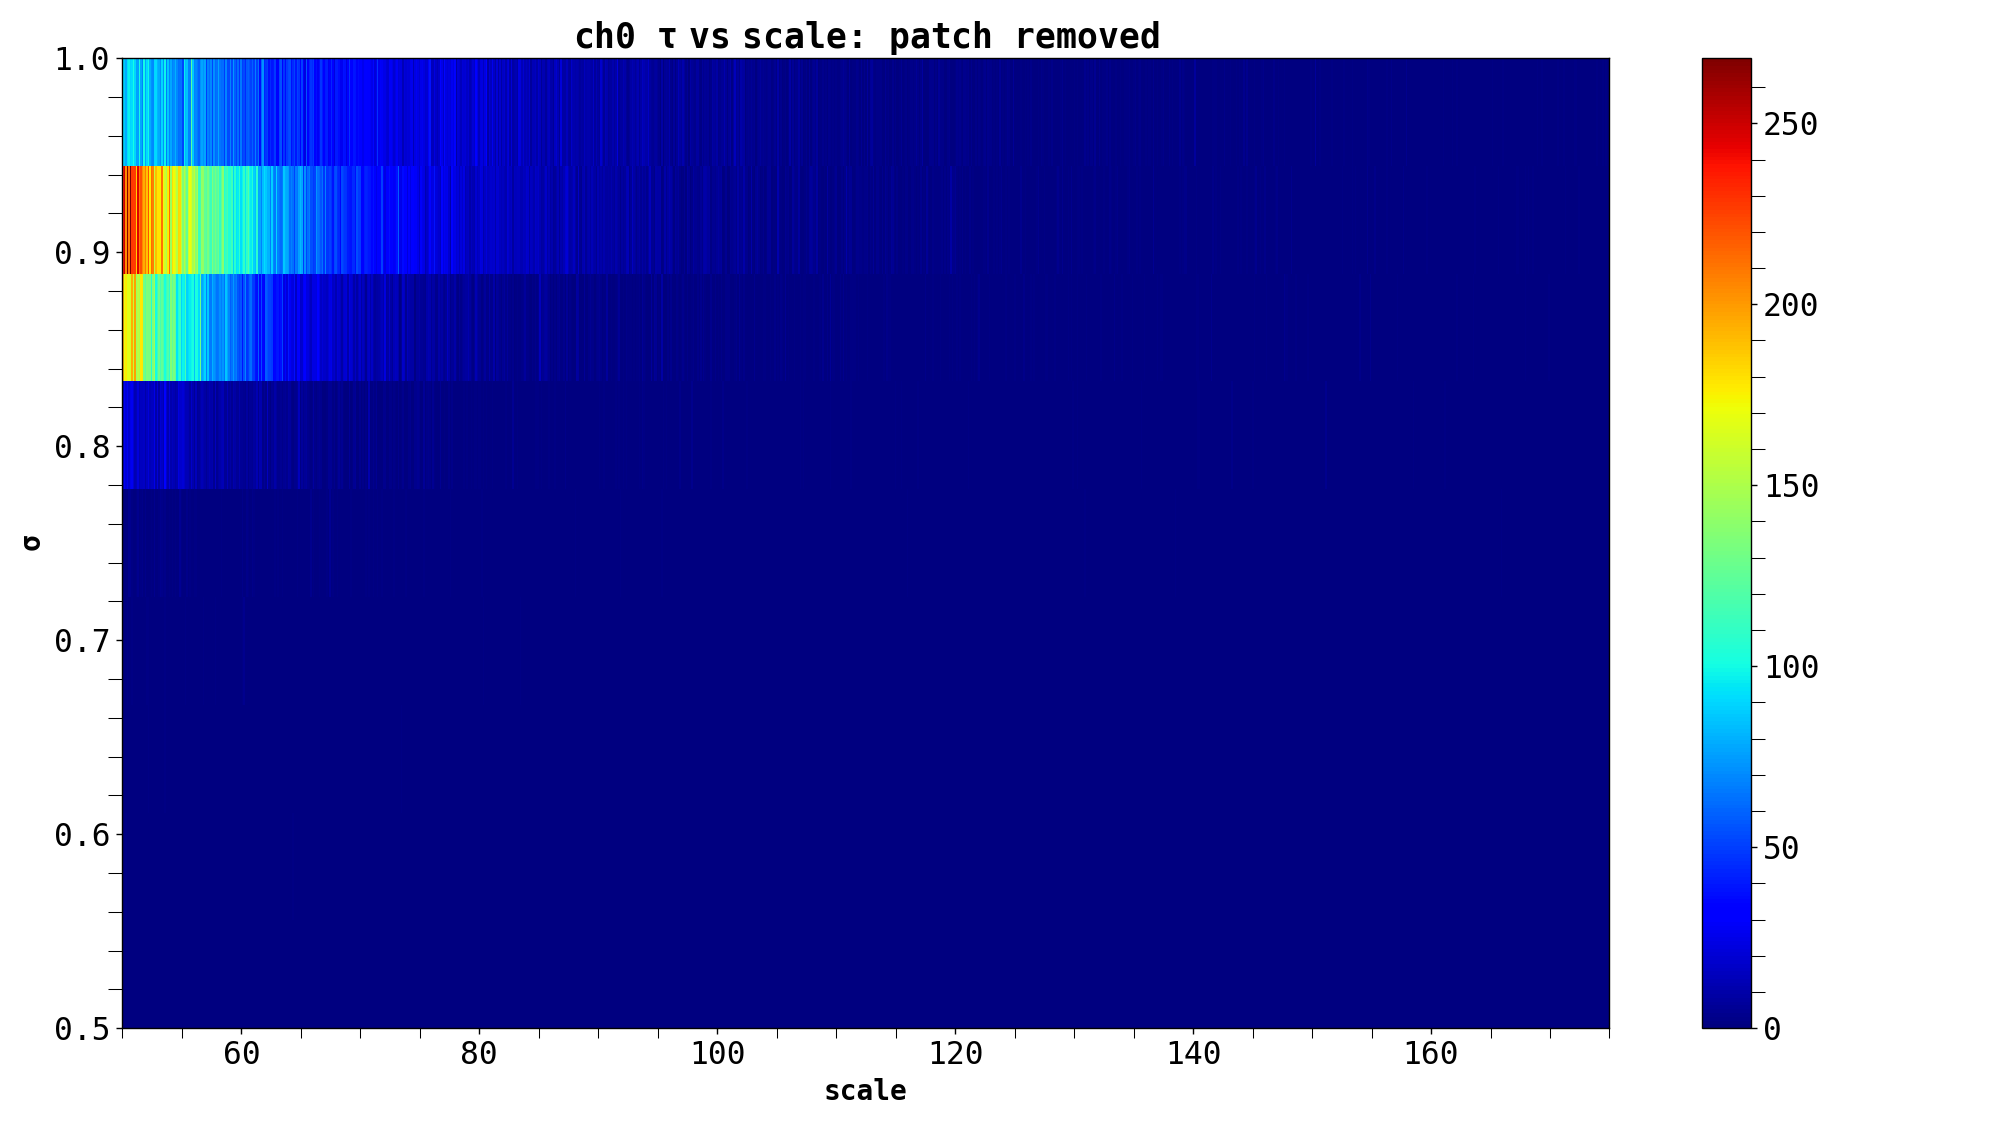

In [83]:
# ch_x = 'ch2'
plt.close(28)
fig28, ax28 = plt.subplots()
hist_h, hist_xedges, hist_yedges, hist_im = ax28.hist2d(param_dict_cut[ch_x]['tau'], \
            param_dict_cut[ch_x]['scale'], bins = [np.linspace(50, 175, 1000), np.linspace(0.5, 1.0, 10)] ,\
            cmap='jet')

ax28.set_xlabel('scale')
ax28.set_ylabel('$\sigma$')
fig28.colorbar(hist_im)
ax28.set_title(f"{ch_x} $\\tau \ vs \ scale $: patch removed");

# 10. <a id='toc10_'></a>[FingerPlot](#toc0_)

In [84]:
# fit_catalogue['ch0'] #TODO invetigate

In [85]:
fit_catalogue[ch_x][(fit_catalogue[ch_x]['chisqr']<2)] #TODO investigate
## almost all events have reduced chisqr > 2. Why? What does this chisqr look like for ch1 and ch2.

,event_counter,wf_ch0,wf_raw,filtered_wf_ch0,fit_param,chisqr
810,20306.0,"[223.0, 248.0, 274.0, 246.0, 246.0, 243.0, 203...","[-23.0, 2.0, 28.0, 0.0, 0.0, -3.0, -43.0, 1.0,...","[-1.9864181334656994, -1.5804185285303116, -1....","[476.00001692143087, 1.3469639666503819, 44.75...",1.658238
21803,2858.0,"[200.0, 177.0, 169.0, 176.0, 200.0, 191.0, 222...","[4.0, -19.0, -27.0, -20.0, 4.0, -5.0, 26.0, -1...","[0.27185563808863056, 0.1996433426221519, 0.57...","[408.56898612260176, 9.999999999850557, 49.648...",1.879602


In [86]:
# ### This integrating window size is not in use.
# # pulse_integration_window_begin = 450
# # pulse_integration_window_end = 650

# integration_vector = np.array([])

# for wf_index in fit_catalogue[ch_x]['wf_raw'].index.values:
#     # if fit_catalogue[ch_x]['chisqr'].loc[wf_index] < 2.0:
#     if True:
#         fitted_param = fit_catalogue[ch_x]['fit_param'][wf_index]
#         fitted_baseline = fitted_param[4]
#         # trace = fit_catalogue[ch_x]['wf_raw'].loc[wf_index] - fitted_baseline
#         trace = fit_catalogue[ch_x][f'filtered_wf_{ch_x}'].loc[wf_index] - fitted_baseline
#         peak_loc =  int(fitted_param[0])
#         # pulse_win_integration_value = np.sum(trace[pulse_integration_window_begin:pulse_integration_window_end]) # fixed window
#         pulse_win_integration_value = np.sum(trace[peak_loc-10:peak_loc+50]) # asymmetric window around peak
#         integration_vector = np.append(integration_vector, pulse_win_integration_value)

In [87]:
# fig99, ax99 = plt.subplots( figsize=(11, 6))
# # hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 2500, 10), color='#B5D9C0', label=ch_x); # peak_loc works for ch1
# ## hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 10000, 25), color='#414B71', label=ch_x); # peak_loc works for ch0
# hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 10000, 25), color='#414B71', label=ch_x); # peak_loc works for ch0
# # hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 2000, 20), color='#AC7774', label='ch2');
# # ax99.set_title(f'Finger plot for {ch_x} \n', fontsize=16)
# ax99.set_xlabel('\n Integrated pulse charge (ADC)')
# ax99.set_ylabel('Counts \n')
# # ax99.legend(bbox_to_anchor=(1.0, 1.0))
# txt_box = offsetbox.TextArea(f"statistics = {len(integration_vector)}", textprops=dict(color='black', backgroundcolor='white', size=16))
# annotation_box_artist = offsetbox.AnnotationBbox(
#                         txt_box, (0.80, 0.88), frameon=True, pad=0.1, xycoords='axes fraction', 
#                         bboxprops=dict(edgecolor='#2D2D2D', linewidth=0.2, boxstyle="square, pad=1.0")
#                         )
# ax99.add_artist(annotation_box_artist)
# # fig99.savefig('../plots/fingerplot_from_flt_ch0.svg')

In [88]:
# pulse_integration_window_begin = 450
# pulse_integration_window_end = 650

integration_vector = np.array([])

for wf_index in fit_catalogue[ch_x]['wf_raw'].index.values[:50000]:
    # if fit_catalogue[ch_x]['chisqr'].loc[wf_index] < 2.0:
    # if True:
    if (fit_catalogue[ch_x]['fit_param'].loc[wf_index][0] < 600) & (fit_catalogue[ch_x]['fit_param'].loc[wf_index][0] > 400):
        fitted_param = fit_catalogue[ch_x]['fit_param'][wf_index]
        fitted_baseline = fitted_param[4]
        # trace = fit_catalogue[ch_x]['wf_raw'].loc[wf_index] - fitted_baseline
        trace = fit_catalogue[ch_x][f'filtered_wf_{ch_x}'].loc[wf_index] - fitted_baseline
        # trace = fit_catalogue[ch_x][f'filtered_wf_{ch_x}'].loc[wf_index] # experimenting
        peak_loc =  int(fitted_param[0])
        # pulse_win_integration_value = np.sum(trace[pulse_integration_window_begin:pulse_integration_window_end]) # fixed window
        # pulse_win_integration_value = np.sum(trace[peak_loc-10:peak_loc+50]) # asymmetric window around peak
        # pulse_win_integration_value = np.sum(trace[peak_loc-20:peak_loc+20]) # specific to FilteredWF
        # pulse_win_integration_value = np.sum(trace[peak_loc-100:peak_loc+100])
        pulse_win_integration_value = np.sum(trace[peak_loc-112:peak_loc+112])
        integration_vector = np.append(integration_vector, pulse_win_integration_value)

In [89]:
# fit_catalogue['ch0']

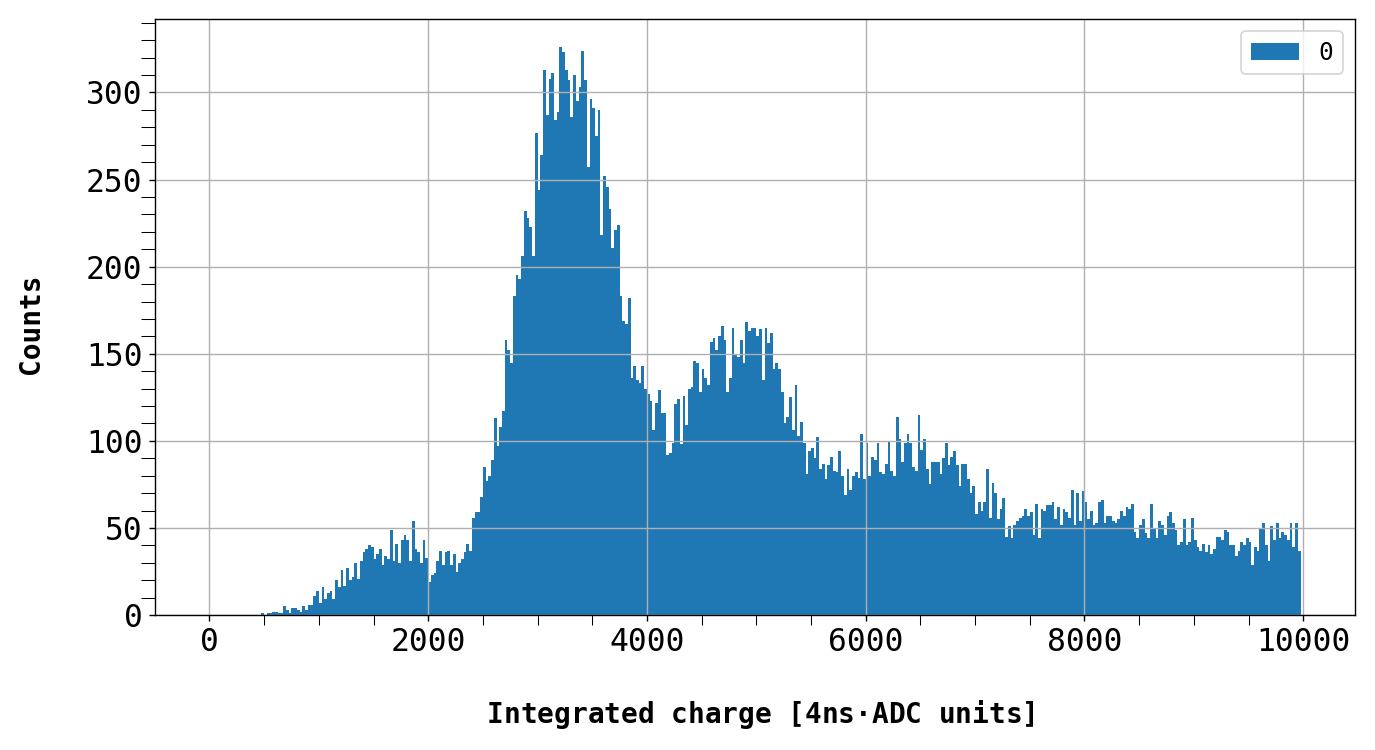

In [90]:
fig100, ax100 = plt.subplots( figsize=(11, 6))
# fig100, ax100 = plt.subplots( figsize=(6, 4))
# hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 2500, 10), color='#B5D9C0', label=ch_x); # peak_loc works for ch1
hist_content, hist_edges, _hist_obj = ax100.hist(integration_vector, bins=np.arange(0, 10000, 25), color='C0', label=ch_x[2]); # peak_loc works for ch0
## hist_content, hist_edges, _hist_obj = ax100.hist(integration_vector, bins=np.arange(0, 8000, 15), color='#414B71', label=ch_x); # peak_loc works for ch0
# hist_content, hist_edges, _hist_obj = ax100.hist(integration_vector, bins=np.arange(0, 2000, 20), color='#AC7774', label='ch2');
# ax100.set_title(f'Finger plot for {ch_x} \n', fontsize=16)
# ax100.set_xlabel('\n Integrated ADC counts')
# ax100.set_ylabel('Frequency \n')    
ax100.set_xlabel('\n Integrated charge [4ns$\cdot$ADC units] ')
ax100.set_ylabel('Counts \n')
# ax99.legend(bbox_to_anchor=(1.0, 1.0))
txt_box = offsetbox.TextArea(f"statistics = {len(integration_vector)}", textprops=dict(color='black', backgroundcolor='white'))
annotation_box_artist = offsetbox.AnnotationBbox(
                        txt_box, (0.80, 0.88), frameon=True, pad=0.1, xycoords='axes fraction', 
                        bboxprops=dict(edgecolor='#2D2D2D', linewidth=0.2, boxstyle="square, pad=1.0")
                        )
# ax100.add_artist(annotation_box_artist)
ax100.legend()
ax100.grid()
# fig100.savefig('../plots/fingerplot_filteredWF_224p0_ch0.png')

In [91]:
ax100.legend()

In [92]:
# fig100.savefig('../plots/fingerplot_filteredWF_224p0_ch0_fitfunc.png')

In [93]:
# stops here

In [94]:
## ax100.axvline(x = 2500, linestyle='--', alpha=0.5, color='grey')
## ax100.axvline(x = 4250, linestyle='--', alpha=0.5, color='magenta')
# ax100.axvline(x = 5725, linestyle='--', alpha=0.5, color='magenta')
# ax100.axvline(x = 2250, linestyle='--', alpha=0.5, color='blue')
# ax100.axvline(x = 4250, linestyle='--', alpha=0.5, color='blue')
# ax100.axvline(x = 4450, linestyle='--', color='magenta', alpha=0.5)
# ax100.axvline(x = 6000, linestyle='--', color='magenta', alpha=0.5)
## ax100.axhline(y = 123, linestyle='--', color='magenta', alpha=0.5,)

## ax100.legend(bbox_to_anchor=(1.0, 0.75))

In [95]:
# fig100.savefig(f'../plots/fingerplotP_filteredWF_200p0_{ch_x}.png')

In [96]:
# fig100.savefig(f'../plots/fingerplotP_filteredWF_224p0_fitfunc_{ch_x}.png')

# 11. <a id='toc11_'></a>[fit gaussian to finger](#toc0_)

## 11.1. <a id='toc11_1_'></a>[First finger](#toc0_)

In [97]:
# np.where(hist_edges <= 4250)

In [98]:
# hist_edges[90]

In [99]:
# hist_edges[82]

In [ ]:
# x_range = range(85, 126) ## ch0 from default

# x_range = range(85, 133) ## ch0

# x_range = range(110, 155) ## filtered ch0
# x_range = range(97, 170) ## filtered ch0 window limit 175
# x_range = range(90, 150) ## filtered ch0 window limit 75
# x_range = range(80, 125) ## filtered ch0 window limit 50
# x_range = range(55, 75) ## filtered ch0 window limit 25
# x_range = range(92, 168) ## filtered ch0 window limit 125
# x_range = range(90, 172) ## filtered ch0 window limit 140
# x_range = range(100, 160) ## filtered ch0 window limit 162
x_range = range(94, 164) ## filtered ch0 window limit 112

# p0_input = [2500, 200, 1200.0] ## ch0
# p0_input = [3300, 425, 100000.0] ## ch0
# p0_input = [3300, 573, 100000.0] ## ch0 window limit 175

# p0_input = [3300, 350, 100000.0] ## ch0 window limit 75
# p0_input = [2500, 270, 100000.0] ## ch0 window limit 50
# p0_input = [1600, 190, 100000.0] ## ch0 window limit 25
p0_input = [3390, 500, 100000.0] ## ch0 window limit 112

bounds_input = ([1000.0, 0.0001, 0.0001], [np.inf, np.inf, np.inf]) ## ch0

fitted_parameters, pcov = curve_fit(f_gauss, 
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input,
                            bounds = bounds_input,
                            sigma = np.sqrt(hist_content[x_range]),
                            absolute_sigma=True,
                            )

red_chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters), fitted_parameters
    )

ax100.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters), color='#FF5733', label='fit')

red_chisqr_value

1.6350047129601237

In [101]:
fitted_parameters

array([      3305,      479.8,  3.719e+05])

In [102]:
perr = np.sqrt(np.diag(pcov))
perr

array([     5.068,      5.231,       3420])

## 11.2. <a id='toc11_2_'></a>[Second finger](#toc0_)

In [103]:
# np.where(hist_edges <= 2860)
# np.where(hist_edges <= 6000)
# hist_edges[178]
# hist_edges[240]

In [104]:
# ax100.axhline(y=82.5, linestyle='--', color='magenta')

In [105]:
# x_range = range(140, 164) ## ch0
# x_range = range(170, 230) ## filtered ch0
# x_range = range(155, 210) ## filtered ch0 window limit 75
# x_range = range(136, 182) ## filtered ch0 window limit 50
# x_range = range(85, 110) ## filtered ch0 window limit 25
# x_range = range(180, 232) ## filtered ch0 window limit 125
# x_range = range(180, 239) ## filtered ch0 window limit 140
# x_range = range(170, 240) ## filtered ch0 window limit 162
x_range = range(170, 229) ## filtered ch0 window limit 112
# x_range = range(170, 230) ## filtered ch0 window limit 112

# p0_input = [3750, 300, 100000.0] ## ch0
# p0_input = [5000, 627, 100000.0] ## filtered ch0
# p0_input = [5375.0, 437, 100000.0] ## filtered ch0 window limit 75
# p0_input = [3900.0, 322, 100000.0] ## filtered ch0 window limit 50
# p0_input = [2400.0, 200, 100000.0] ## filtered ch0 window limit 25
# p0_input = [5110.0, 460, 100000.0] ## filtered ch0 window limit 125
# p0_input = [5110.0, 460, 100000.0] ## filtered ch0 window limit 140
# p0_input = [5320.0, 460, 100000.0] ## filtered ch0 window limit 162
p0_input = [5000.0, 320, 100000.0] ## filtered ch0 window limit 112
bounds_input = ([1000.0, 0.0001, 0.0001], [np.inf, np.inf, np.inf]) ## ch0
fitted_parameters, pcov = curve_fit(f_gauss, 
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input,
                            bounds = bounds_input,
                            sigma = np.sqrt(hist_content[x_range]),
                            absolute_sigma=True,
                            )

red_chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters), fitted_parameters
    )

ax100.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters), color='#28A745', linewidth=2.2, label='fit')

red_chisqr_value

1.0906808900554823

In [106]:
## standard deviation from covariance matrix
perr = np.sqrt(np.diag(pcov))
perr

array([        17,         26,       7941])

In [107]:
fitted_parameters

array([      4823,      697.4,  2.726e+05])

In [108]:
# how likely are these chisqr values?
# from scipy import stats
# stats.chi2.pdf(1.02 , 68)

# 12. <a id='toc12_'></a>[SPE charge](#toc0_)

In [109]:
## ch0
## instruction: difference of means of first two peaks
# print(f"SPE charge: {3770 - 2517}") ### ch0 from default
# print(f"SPE charge: {1973 - 1316}") ### filtered ch0 from default
# print(f"SPE charge: {4872 - 3296}") ### filtered ch0 from default
# print(f"SPE charge: {4985 - 3480}") ### filtered ch0 from default +/- 150
# print(f"SPE charge: {4913 - 3553}") ### filtered ch0 from default +/- 175
# print(f"SPE charge: {4539 - 3072}") ### filtered ch0 from default +/- 75
# print(f"SPE charge: {3881 - 2595}") ### filtered ch0 from default +/- 50
# print(f"SPE charge: {2408 - 1603}") ### filtered ch0 from default +/- 25
# print(f"SPE charge: {5028 - 3442}") ### filtered ch0 from default +/- 125
# print(f"SPE charge: {5072 - 3490}") ### filtered ch0 from default +/- 140
# print(f"SPE charge: {4989 - 3523}") ### filtered ch0 from default +/- 162
# print(f"SPE charge: {4941 - 3381}") ### filtered ch0 from default +/- 112
# print(f"SPE charge: { 4963 - 3399}") ### filtered ch0 from default +/- 112 # this is what went to the LIDINE presentation
print(f"SPE charge: { 4823 - 3305}") ### filtered ch0 from default +/- 112 # not removing the rectangular patch for ch0

SPE charge: 1518


In [110]:
## error in SPE charge using error propagation
# f"Error: {np.sqrt((3.377)**2 + (5.697)**2)}"
# f"Error: {np.sqrt((1.305)**2 + (2.094)**2)}"  ### filtered ch0
# f"Error: {np.sqrt((6.511)**2 + (12.48)**2)}"  ### filtered ch0
# f"Error: {np.sqrt((14.13)**2 + (34.38)**2)}"  ### filtered ch0 +/- 150
# f"Error: {np.sqrt((8.845)**2 + (51.08)**2)}"  ### filtered ch0 +/- 175
# f"Error: {np.sqrt((3.91)**2 + (8.693)**2)}"  ### filtered ch0 +/- 75
# f"Error: {np.sqrt((2.955)**2 + (6.027)**2)}"  ### filtered ch0 +/- 50
# f"Error: {np.sqrt((2.001)**2 + (2.995)**2)}"  ### filtered ch0 +/- 25
# f"Error: {np.sqrt((6.003)**2 + (17.78)**2)}"  ### filtered ch0 +/- 125
# f"Error: {np.sqrt((6.418)**2 + (21.98)**2)}"  ### filtered ch0 +/- 140
# f"Error: {np.sqrt((12.52)**2 + (30.43)**2)}"  ### filtered ch0 +/- 162
# f"Error: {np.sqrt((5.515)**2 + (12.35)**2)}"  ### filtered ch0 +/- 112
# f"Error: {np.sqrt((5.831)**2 + (13.35)**2)}"  ### filtered ch0 +/- 112 # this is what went to the LIDINE presentation
f"Error: {np.sqrt((5.07)**2 + (17)**2)}" #  not removing the rectangular patch for ch0

'Error: 17.739923900625957'

# 13. <a id='toc13_'></a>[SNR](#toc0_)

In [111]:
## instruction Signal to Noise Ration (SNR) given by that SPE charge divided by Gaussian sigma of the first peak. First peak = pedestal?
## since we only have access to the second peak, you can use instead its sigma, divided by sqrt(2)
## (this is because sigma of a convolution of two identical gauss distributions is sqrt(2 * sigma^2) ) ## convolution of which distributions? why convolution?

## 13.1. <a id='toc13_1_'></a>[Noise term](#toc0_)

In [112]:
integration_range = [0, 225]

In [113]:
pretrigger_sum_ls = []
for loop_index in fit_catalogue[ch_index].index.values:
    pretrigger_sum = np.sum(fit_catalogue[ch_index].loc[loop_index]['filtered_wf_ch0'][integration_range[0]:integration_range[1]])  #TODO: where should the integration window start? Do this on raw or filtered?
    pretrigger_sum_ls.append(pretrigger_sum)

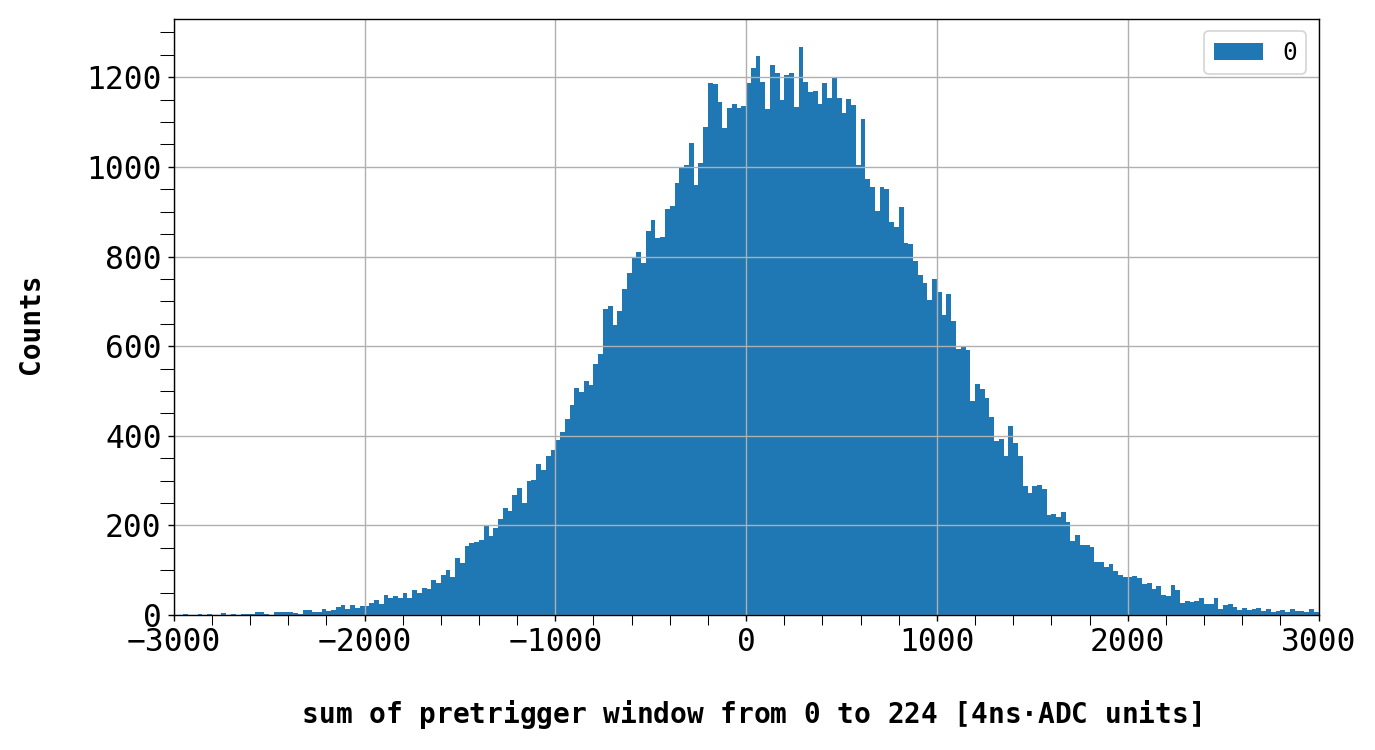

In [114]:
fig101, ax101 = plt.subplots( figsize=(11, 6))
# fig101, ax101 = plt.subplots( figsize=(6, 4))
hist_content, hist_edges, _hist_obj = ax101.hist(pretrigger_sum_ls, 
                                                # bins=np.arange(0, 2500, 10),
                                                bins=np.arange(-5000, 15000, 25),
                                                # bins=np.arange(-5000, 15000, 50),
                                                # bins=np.arange(-5000, 15000, 100),
                                                # color='#B5D9C0', label=ch_x);
                                                color=f'C{ch_x[2]}', label=ch_x[2]); 
ax101.legend()
ax101.set_xlim(-3000, 3000)
ax101.set_xlabel(f'\n sum of pretrigger window from {integration_range[0]} to {integration_range[1]-1} [4ns$\cdot$ADC units] ')
ax101.set_ylabel('Counts \n')
ax101.grid()

In [115]:
# p0_input = [150, 856, 1000] ## ch0
p0_input = [150, 856, 1E6] ## ch0
bounds_input = ([-400, 100, 1], [1000, 1E5, np.inf]) ## ch0

# x_range = range(40, 60) # bins=np.arange(-5000, 15000, 100),
x_range = range(125, 275)

fitted_parameters, pcov = curve_fit(f_gauss, 
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input,
                            bounds = bounds_input,
                            # sigma = np.sqrt(hist_content[x_range]),
                            absolute_sigma=True,
                            )

red_chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters), fitted_parameters
    )

ax101.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters), color='#FF5733', label='fit')
ax101.legend()

text_in_box = AnchoredText(f"statistics = {len(pretrigger_sum_ls)} \n$\\chi^{2}/\\nu$ = {red_chisqr_value:.2f} \n$\\mu$ = {fitted_parameters[0]:.3f} \n$\\sigma$ = {fitted_parameters[1]:.3f} \nCOM = {calc_COM(hist_content, hist_edges):.3f}", \
                                       loc='upper left')
text_in_box.patch.set_alpha(0.1)
ax101.add_artist(text_in_box)
print(f'red_chisqr_value: {red_chisqr_value:.3f}')
print(f'fitted_parameters: {fitted_parameters}')

red_chisqr_value: 1.598
fitted_parameters: [     165.1      787.7  2.391e+06]


In [116]:
# 2000/2.335

In [117]:
# np.where(hist_edges <= 2500)

## 13.2. <a id='toc13_2_'></a>[SNR calculation](#toc0_)

In [118]:
# SPE_charge = 1253
# sigma_1 = 241.3
# SNR = SPE_charge/(sigma_1/np.sqrt(2))

# SPE_charge = 1576
# sigma_1 = 454.8

SPE_charge = 1564
sigma_1 = 494.7

# ways to calulate SNR
# SNR = SPE_charge/(sigma_1/np.sqrt(2)) # sPE/(width of 1PE peak) or sPE/(width of pedestal) or sPE/(RMS of baseline)
# sPE/(width of 1PE peak) or sPE/(width of pedestal) or sPE/(RMS of baseline)

In [119]:
# sPE/((width of 2PE peak)/np.sqrt(2)) # width of first peak estimated from second peak. We are trying to get the width of 1PE though we can not reliably get a number for it directly.

SNR = SPE_charge/(sigma_1/np.sqrt(2)) 

f"SNR: {SNR:.2f}"

'SNR: 4.47'

In [120]:
# sPE/(width of pedestal)

SNR = SPE_charge/(fitted_parameters[1])

f"SNR: {SNR:.2f}"

'SNR: 1.99'

In [121]:
# sum of 224 bins on each waveform --> 1 sum value 
# 100k waveforms --> distribution --> std --> sPE/std gives the SNR

<hr style="border: none; border-bottom: 5px solid blue;"> </hr>